In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

print("Path to dataset files:", path)
train_path = "/kaggle/input/credit-score-classification/train.csv"

Using Colab cache for faster access to the 'credit-score-classification' dataset.
Path to dataset files: /kaggle/input/credit-score-classification


In [32]:
"""
Credit Score Data Explorer and Analyzer
=======================================
This class provides comprehensive exploratory data analysis (EDA) and statistical insights
for credit scoring dataset, helping understand data quality issues and cleaning requirements.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Dict, List, Tuple, Any
from collections import Counter

warnings.filterwarnings('ignore')
plt.style.use('default')

class CreditDataExplorer:
    """
    Comprehensive data exploration and analysis class for credit scoring data.

    This class provides:
    - Data quality assessment and corruption detection
    - Statistical summaries and distributions
    - Missing value analysis with business context
    - Data visualization and insights
    - Recommendations for cleaning strategies
    """

    def __init__(self, file_path: str):
        """Initialize the explorer with data file."""
        self.file_path = file_path
        self.df = None
        self.setup_display_options()
        self.setup_plotting()

    def setup_display_options(self):
        """Configure pandas display options for better data inspection."""
        pd.set_option('display.max_columns', 1000)
        pd.set_option('display.max_rows', 100)
        pd.set_option('display.float_format', lambda x: '%.5f' % x)

    def setup_plotting(self):
        """Configure matplotlib and seaborn for better visualizations."""
        plt.rcParams['figure.figsize'] = (12, 8)
        sns.set_palette("husl")

    def load_and_inspect_raw_data(self) -> pd.DataFrame:
        """Load data and perform initial inspection."""
        print("🔍 LOADING AND INSPECTING RAW DATA")
        print("="*60)

        self.df = pd.read_csv(self.file_path)
        self.df.columns = self.df.columns.str.lower()

        print(f"📊 Dataset Shape: {self.df.shape}")
        print(f"📈 Total Records: {self.df.shape[0]:,}")
        print(f"📋 Total Features: {self.df.shape[1]}")
        print(f"👥 Unique Customers: {self.df['customer_id'].nunique():,}")
        print(f"📅 Records per Customer: {self.df.shape[0] / self.df['customer_id'].nunique():.1f} avg")

        return self.df

    def analyze_data_types_and_structure(self):
        """Analyze data types and identify structure issues."""
        print("\n🔢 DATA TYPES AND STRUCTURE ANALYSIS")
        print("="*60)

        print("Data Types Distribution:")
        dtype_counts = self.df.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"  {dtype}: {count} columns")

        print(f"\nColumns Info:")
        print(self.df.info())

        # Identify object columns that should be numeric
        object_cols = self.df.select_dtypes(include=['object']).columns.tolist()
        potentially_numeric = []

        for col in object_cols:
            if col not in ['customer_id', 'name', 'ssn', 'occupation', 'type_of_loan',
                          'credit_mix', 'payment_of_min_amount', 'payment_behaviour']:
                potentially_numeric.append(col)

        if potentially_numeric:
            print(f"\n⚠️  Object columns that might be numeric: {potentially_numeric}")

    def detect_data_corruption(self):
        """Detect and analyze data corruption patterns."""
        print("\n🚨 DATA CORRUPTION DETECTION")
        print("="*60)

        corruption_found = {}

        # Check for extreme values wrapped in underscores
        extreme_patterns = ['__-333333333333333333333333333__', '__10000__']

        for pattern in extreme_patterns:
            affected_cols = []
            for col in self.df.columns:
                if self.df[col].astype(str).str.contains(pattern, na=False).any():
                    count = self.df[col].astype(str).str.contains(pattern, na=False).sum()
                    affected_cols.append(f"{col}({count})")

            if affected_cols:
                corruption_found[pattern] = affected_cols
                print(f"🔴 Pattern '{pattern}' found in: {', '.join(affected_cols)}")

        # Check for random character patterns
        random_patterns = ['!@9#%8', '#F%$D@*&8', 'NM', 'nm']
        for pattern in random_patterns:
            affected_cols = []
            for col in self.df.columns:
                if self.df[col].astype(str).str.contains(pattern, na=False).any():
                    count = self.df[col].astype(str).str.contains(pattern, na=False).sum()
                    affected_cols.append(f"{col}({count})")

            if affected_cols:
                corruption_found[pattern] = affected_cols
                print(f"🟡 Random pattern '{pattern}' found in: {', '.join(affected_cols)}")

        # Check for underscore wrapping
        underscore_wrapped = 0
        for col in self.df.columns:
            if col not in ['customer_id']:
                wrapped_count = self.df[col].astype(str).str.match(r'^_.*_$').sum()
                if wrapped_count > 0:
                    underscore_wrapped += wrapped_count
                    print(f"🟠 Column '{col}' has {wrapped_count} underscore-wrapped values")

        if underscore_wrapped > 0:
            print(f"📊 Total underscore-wrapped values: {underscore_wrapped}")

        if not corruption_found and underscore_wrapped == 0:
            print("✅ No obvious data corruption patterns detected!")

        return corruption_found

    def analyze_missing_values(self):
        """Comprehensive missing value analysis with business context."""
        print("\n❓ MISSING VALUES ANALYSIS")
        print("="*60)

        missing_summary = self.df.isnull().sum()
        missing_percentage = (missing_summary / len(self.df)) * 100

        missing_df = pd.DataFrame({
            'Column': missing_summary.index,
            'Missing_Count': missing_summary.values,
            'Missing_Percentage': missing_percentage.values
        }).sort_values('Missing_Percentage', ascending=False)

        missing_cols = missing_df[missing_df['Missing_Count'] > 0]

        if len(missing_cols) > 0:
            print("Missing Values Summary:")
            for _, row in missing_cols.iterrows():
                print(f"  📝 {row['Column']}: {row['Missing_Count']} ({row['Missing_Percentage']:.2f}%)")

            # Visualize missing values
            plt.figure(figsize=(12, 8))
            sns.heatmap(self.df.isnull(), cmap='viridis', cbar=True, yticklabels=False)
            plt.title('Missing Values Heatmap')
            plt.tight_layout()
            plt.show()

            # Missing values by customer analysis
            customer_missing = self.df.groupby('customer_id').apply(lambda x: x.isnull().sum().sum())
            print(f"\n👥 Customer-level missing values:")
            print(f"  Average missing values per customer: {customer_missing.mean():.2f}")
            print(f"  Max missing values for a customer: {customer_missing.max()}")
            print(f"  Customers with no missing values: {(customer_missing == 0).sum()}")

        else:
            print("✅ No missing values found!")

        return missing_df

    def analyze_target_variable(self):
        """Analyze the target variable (credit_score) distribution and patterns."""
        print("\n🎯 TARGET VARIABLE ANALYSIS")
        print("="*60)

        if 'credit_score' not in self.df.columns:
            print("❌ Credit score column not found!")
            return

        # Basic statistics
        credit_counts = self.df['credit_score'].value_counts(dropna=False)
        credit_pct = self.df['credit_score'].value_counts(normalize=True, dropna=False) * 100

        print("Credit Score Distribution:")
        for score in credit_counts.index:
            count = credit_counts[score]
            pct = credit_pct[score]
            print(f"  📊 {score}: {count:,} ({pct:.2f}%)")

        # Check for class imbalance
        max_pct = credit_pct.max()
        min_pct = credit_pct.min()
        imbalance_ratio = max_pct / min_pct

        if imbalance_ratio > 2:
            print(f"⚠️  Class imbalance detected! Ratio: {imbalance_ratio:.2f}:1")
        else:
            print(f"✅ Classes are relatively balanced. Ratio: {imbalance_ratio:.2f}:1")

        # Visualizations
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Count plot
        sns.countplot(data=self.df, x='credit_score', ax=axes[0])
        axes[0].set_title('Credit Score Distribution (Counts)')
        axes[0].set_ylabel('Count')

        # Pie chart
        axes[1].pie(credit_counts.values, labels=credit_counts.index, autopct='%1.1f%%')
        axes[1].set_title('Credit Score Distribution (Percentages)')

        plt.tight_layout()
        plt.show()

        # Customer-level analysis
        customer_scores = self.df.groupby('customer_id')['credit_score'].agg(['nunique', 'first', 'last'])

        score_changes = (customer_scores['first'] != customer_scores['last']).sum()
        stable_scores = (customer_scores['first'] == customer_scores['last']).sum()

        print(f"\n📈 Customer Score Stability:")
        print(f"  Customers with changing scores: {score_changes} ({score_changes/len(customer_scores)*100:.1f}%)")
        print(f"  Customers with stable scores: {stable_scores} ({stable_scores/len(customer_scores)*100:.1f}%)")

        if score_changes > 0:
            print("💡 Insight: Score changes over time suggest temporal modeling opportunities")

    def analyze_numerical_features(self):
        """Analyze numerical features with statistical insights."""
        print("\n📊 NUMERICAL FEATURES ANALYSIS")
        print("="*60)

        # Identify numerical columns
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        if 'credit_score' in numerical_cols:
            numerical_cols.remove('credit_score')  # Handle separately

        print(f"Found {len(numerical_cols)} numerical features")

        # Basic statistics
        desc_stats = self.df[numerical_cols].describe()
        print("\nBasic Statistics:")
        print(desc_stats)

        # Check for outliers using IQR method
        print("\n🚨 OUTLIER ANALYSIS:")
        outlier_summary = []

        for col in numerical_cols:
            if self.df[col].dtype in [int, float]:
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)][col]
                outlier_count = len(outliers)
                outlier_percentage = (outlier_count / len(self.df)) * 100

                if outlier_count > 0:
                    outlier_summary.append({
                        'Column': col,
                        'Outlier_Count': outlier_count,
                        'Outlier_Percentage': outlier_percentage,
                        'Lower_Bound': lower_bound,
                        'Upper_Bound': upper_bound
                    })

        if outlier_summary:
            outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Percentage', ascending=False)
            print("Outliers Summary:")
            for _, row in outlier_df.iterrows():
                print(f"  📊 {row['Column']}: {row['Outlier_Count']} outliers ({row['Outlier_Percentage']:.2f}%)")
        else:
            print("✅ No significant outliers detected using IQR method!")

        # Correlation analysis
        print("\n🔗 CORRELATION ANALYSIS:")
        corr_matrix = self.df[numerical_cols].corr()

        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_value = corr_matrix.iloc[i, j]
                if abs(corr_value) > 0.7:  # High correlation threshold
                    high_corr_pairs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_value
                    ))

        if high_corr_pairs:
            print("Highly correlated feature pairs (|r| > 0.7):")
            for col1, col2, corr in high_corr_pairs:
                print(f"  🔗 {col1} ↔ {col2}: {corr:.3f}")
        else:
            print("✅ No highly correlated feature pairs found!")

        # Visualize correlation matrix
        if len(numerical_cols) <= 15:  # Only plot if manageable number of features
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                       square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
            plt.title('Correlation Matrix of Numerical Features')
            plt.tight_layout()
            plt.show()

    def analyze_categorical_features(self):
        """Analyze categorical features and their distributions."""
        print("\n📋 CATEGORICAL FEATURES ANALYSIS")
        print("="*60)

        categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()

        # Remove ID columns
        id_cols = ['customer_id', 'name', 'ssn']
        categorical_cols = [col for col in categorical_cols if col not in id_cols]

        print(f"Found {len(categorical_cols)} categorical features")

        for col in categorical_cols:
            print(f"\n📊 {col.upper()}:")
            value_counts = self.df[col].value_counts(dropna=False)
            unique_values = self.df[col].nunique()

            print(f"  📈 Unique values: {unique_values}")
            print(f"  🔝 Top categories:")

            # Show top 10 categories
            for idx, (category, count) in enumerate(value_counts.head(10).items()):
                percentage = (count / len(self.df)) * 100
                print(f"    {idx+1}. {category}: {count} ({percentage:.2f}%)")

            if unique_values > 10:
                print(f"    ... and {unique_values - 10} more categories")

            # Check for data quality issues in categorical columns
            if col == 'type_of_loan':
                # Special analysis for loan types
                self._analyze_loan_types()

    def _analyze_loan_types(self):
        """Special analysis for loan types column."""
        print(f"\n🏦 DETAILED LOAN TYPES ANALYSIS:")

        # Extract individual loan types
        loan_series = self.df['type_of_loan'].dropna()
        all_loans = []

        for loan_str in loan_series:
            # Split by various delimiters
            loans = str(loan_str).split(', and ')
            for loan_group in loans:
                individual_loans = loan_group.split(', ')
                all_loans.extend([loan.strip('_').strip() for loan in individual_loans])

        loan_counts = Counter(all_loans)
        print(f"  📊 Individual loan type frequencies:")
        for loan_type, count in loan_counts.most_common(10):
            if loan_type and loan_type != 'and':
                percentage = (count / len(self.df)) * 100
                print(f"    {loan_type}: {count} ({percentage:.1f}%)")

    def generate_data_insights_report(self):
        """Generate comprehensive insights and recommendations."""
        print("\n💡 DATA INSIGHTS AND RECOMMENDATIONS")
        print("="*60)

        insights = []

        # Missing values insights
        missing_summary = self.df.isnull().sum()
        high_missing_cols = missing_summary[missing_summary > len(self.df) * 0.1].index.tolist()

        if high_missing_cols:
            insights.append(f"🔍 High missing values in: {', '.join(high_missing_cols)}")
            insights.append("   Recommendation: Consider customer-grouped imputation strategies")

        # Temporal data insights
        customers_with_multiple_records = (self.df['customer_id'].value_counts() > 1).sum()
        if customers_with_multiple_records > 0:
            insights.append(f"📅 {customers_with_multiple_records} customers have multiple records")
            insights.append("   Recommendation: Use customer-based train/test split to prevent data leakage")

        # Target variable insights
        if 'credit_score' in self.df.columns:
            score_distribution = self.df['credit_score'].value_counts()
            if len(score_distribution) > 1:
                max_class_pct = (score_distribution.max() / len(self.df)) * 100
                if max_class_pct > 60:
                    insights.append(f"⚖️  Class imbalance detected ({max_class_pct:.1f}% majority class)")
                    insights.append("   Recommendation: Consider stratified sampling and balanced metrics")

        # Correlation insights
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numerical_cols) > 2:
            corr_matrix = self.df[numerical_cols].corr()
            high_corr_count = (corr_matrix.abs() > 0.8).sum().sum() - len(numerical_cols)  # Exclude diagonal
            if high_corr_count > 0:
                insights.append(f"🔗 {high_corr_count//2} highly correlated feature pairs detected")
                insights.append("   Recommendation: Consider feature selection or PCA for multicollinearity")

        # Data quality insights
        corruption_patterns = self.detect_data_corruption()
        if corruption_patterns:
            insights.append("🚨 Data corruption patterns detected")
            insights.append("   Recommendation: Clean corrupted values before modeling")

        print("Key Insights:")
        for insight in insights:
            print(f"  {insight}")

        if not insights:
            print("✅ Data appears to be in good condition for modeling!")

        return insights

    def run_full_exploration(self):
        """Execute the complete data exploration pipeline."""
        print("🔍 STARTING COMPREHENSIVE DATA EXPLORATION")
        print("="*80)

        # Load and inspect
        self.load_and_inspect_raw_data()

        # Structure analysis
        self.analyze_data_types_and_structure()

        # Data quality
        self.detect_data_corruption()

        # Missing values
        self.analyze_missing_values()

        # Target analysis
        self.analyze_target_variable()

        # Feature analysis
        self.analyze_numerical_features()
        self.analyze_categorical_features()

        # Final insights
        insights = self.generate_data_insights_report()

        print("\n" + "="*80)
        print("✅ EXPLORATION COMPLETED! Use insights to guide your cleaning strategy.")
        print("="*80)

        return {
            'dataframe': self.df,
            'insights': insights,
            'summary_stats': self.df.describe(),
            'missing_values': self.df.isnull().sum(),
            'data_types': self.df.dtypes
        }

In [33]:
"""
Credit Score Data Preprocessing Pipeline
======================================
This script handles comprehensive data cleaning, imputation, and feature engineering
for credit scoring dataset with temporal customer data.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import List, Union

warnings.filterwarnings('ignore')

class CreditDataPreprocessor:
    """
    A comprehensive data preprocessing pipeline for credit scoring data.

    This class handles:
    - Data cleaning and corruption removal
    - Missing value imputation with customer-aware logic
    - Feature engineering and encoding
    - Outlier detection and treatment
    """

    def __init__(self, file_path: str):
        """Initialize the preprocessor with data file."""
        self.file_path = file_path
        self.df = None
        self.setup_display_options()

    def setup_display_options(self):
        """Configure pandas display options for better data inspection."""
        pd.set_option('display.max_columns', 1000)
        pd.set_option('display.max_rows', 1000)
        pd.set_option('display.float_format', lambda x: '%.5f' % x)

    def load_data(self) -> pd.DataFrame:
        """Load and perform initial data preparation."""
        print("Loading data...")
        self.df = pd.read_csv(self.file_path)
        self.df.columns = self.df.columns.str.lower()
        print(f"Data loaded: {self.df.shape}")
        return self.df

    def remove_irrelevant_columns(self) -> pd.DataFrame:
        """Remove columns that don't contribute to credit scoring."""
        columns_to_drop = ['id', 'name', 'ssn','month']
        self.df = self.df.drop(columns_to_drop, axis=1)
        print(f"Dropped irrelevant columns: {columns_to_drop}")
        return self.df

    def clean_corrupted_data(self) -> pd.DataFrame:
        """
        Remove corrupted and invalid data patterns found in the dataset.

        Handles:
        - Extreme values wrapped in underscores
        - Random character patterns
        - Empty strings and various null representations
        """
        print("Cleaning corrupted data...")

        # Handle specific extreme corrupted values
        extreme_value_mapping = {
            '__-333333333333333333333333333__': np.nan,
            '__10000__': np.nan
        }
        self.df.replace(extreme_value_mapping, inplace=True)

        # Define invalid patterns found in the data
        invalid_patterns = ['', 'nan', '!@9#%8', '#F%$D@*&8', 'NM', 'nm']

        # Strip underscores and replace invalid patterns
        self.df = self.df.applymap(
            lambda x: x if x is np.nan or not isinstance(x, str)
            else str(x).strip('_')
        ).replace(invalid_patterns, np.nan)

        print("Corrupted data patterns cleaned")
        return self.df

    def convert_data_types(self) -> pd.DataFrame:
        """Convert columns to appropriate data types after cleaning."""
        print("Converting data types...")

        # Numeric columns that should be converted
        numeric_conversions = {
            'age': int,
            'annual_income': float,
            'num_of_loan': int,
            'num_of_delayed_payment': float,
            'changed_credit_limit': float,
            'outstanding_debt': float,
            'amount_invested_monthly': float,
            'monthly_balance': float
        }

        for col, dtype in numeric_conversions.items():
            try:
                self.df[col] = self.df[col].astype(dtype)
            except ValueError as e:
                print(f"Warning: Could not convert {col} to {dtype}: {e}")

        return self.df

    def standardize_string_columns(self) -> pd.DataFrame:
        """Standardize string columns to lowercase with underscores."""
        string_columns = list(self.df.dtypes[self.df.dtypes == 'object'].index)

        for col in string_columns:
            self.df[col] = self.df[col].str.lower().str.replace(' ', '_')

        print(f"Standardized {len(string_columns)} string columns")
        return self.df

    def handle_customer_stable_features(self) -> pd.DataFrame:
        """
        Handle features that should be stable within each customer's timeline.
        Uses forward/backward fill within customer groups.
        """
        print("Handling customer-stable features...")

        stable_features = ['occupation']

        for feature in stable_features:
            # Forward fill then backward fill within customer groups
            self.df[feature] = self.df.groupby(
                'customer_id')[feature].fillna(method='ffill')
            self.df[feature] = self.df.groupby(
                'customer_id')[feature].fillna(method='bfill')

        return self.df

    def clean_age_column(self) -> pd.DataFrame:
        """Clean age column with business logic validation."""
        print("Cleaning age column...")

        # Set unrealistic ages to NaN (based on data analysis: 14-60 range)
        self.df.loc[(self.df['age'] < 14) | (
            self.df['age'] > 60), 'age'] = np.nan

        # Fill missing ages within customer groups
        self.df['age'] = self.df.groupby('customer_id')['age'].fillna(
            method='ffill').fillna(method='bfill')

        return self.df

    def parse_credit_history_age(self, x) -> Union[float, int]:
        """Parse credit history age from text format to months."""
        if pd.isna(x) or str(x).lower() == 'na':
            return np.nan

        parts = str(x).replace('_', ' ').split(' and ')
        years = int(parts[0].split(' ')[0]) * 12
        months = int(parts[1].split(' ')[0])

        return years + months

    def fill_credit_history_sequential(self, group) -> pd.Series:
        """
        Fill missing credit history values considering monthly progression.
        Credit history should increment by 1 each month.
        """
        group = group.copy()

        # Forward fill with increment
        for i in range(1, len(group)):
            if pd.isna(group.iloc[i]) and not pd.isna(group.iloc[i-1]):
                group.iloc[i] = group.iloc[i-1] + 1

        # Backward fill with decrement
        for i in range(len(group)-2, -1, -1):
            if pd.isna(group.iloc[i]) and not pd.isna(group.iloc[i+1]):
                group.iloc[i] = group.iloc[i+1] - 1

        return group

    def handle_credit_history_age(self) -> pd.DataFrame:
        """Transform and impute credit history age column."""
        print("Processing credit history age...")

        # Replace 'na' strings with proper NaN
        self.df['credit_history_age'] = self.df['credit_history_age'].replace({
                                                                              'na': np.nan})

        # Parse text format to numeric (months)
        self.df['credit_history_age'] = self.df['credit_history_age'].apply(
            self.parse_credit_history_age)

        # Apply sequential filling within customer groups
        self.df['credit_history_age'] = self.df.groupby('customer_id')['credit_history_age'].apply(
            self.fill_credit_history_sequential
        ).reset_index(level=0, drop=True)

        return self.df

    def impute_customer_grouped_features(self) -> pd.DataFrame:
        """Impute missing values using customer-grouped statistics."""
        print("Imputing customer-grouped features...")

        # Features that should be filled within customer groups
        customer_grouped_features = {
            'monthly_inhand_salary': 'ffill_bfill',
            'credit_mix': 'ffill_bfill',
            'payment_of_min_amount': 'mode',
            'payment_behaviour': 'mode_safe',
            'num_of_delayed_payment': 'median',
            'changed_credit_limit': 'median'
        }

        for feature, method in customer_grouped_features.items():
            if method == 'ffill_bfill':
                self.df[feature] = self.df.groupby(
                    'customer_id')[feature].fillna(method='ffill')
                self.df[feature] = self.df.groupby(
                    'customer_id')[feature].fillna(method='bfill')

            elif method == 'mode':
                self.df[feature] = self.df.groupby('customer_id')[feature].transform(
                    lambda x: x.mode()[0] if not x.mode().empty else np.nan
                )

            elif method == 'mode_safe':
                self.df[feature] = self.df.groupby('customer_id')[feature].transform(
                    lambda x: x.fillna(
                        x.mode()[0] if not x.mode().empty else 'unknown')
                )

            elif method == 'median':
                self.df[feature] = self.df.groupby('customer_id')[feature].transform(
                    lambda x: x.median() if not x.isnull().all() else np.nan
                )

        return self.df

    def handle_remaining_missing_values(self) -> pd.DataFrame:
        """Handle remaining missing values with appropriate strategies."""
        print("Handling remaining missing values...")

        # Mean imputation for balance-related features
        mean_imputation_cols = ['monthly_balance', 'amount_invested_monthly']
        for col in mean_imputation_cols:
            self.df[col] = self.df.groupby('customer_id')[col].transform(
                lambda x: x.fillna(x.mean())
            )

        # Median imputation for count-based features with zero handling
        median_imputation_cols = ['num_of_loan', 'num_credit_inquiries',
                                  'num_bank_accounts', 'total_emi_per_month']

        for col in median_imputation_cols:
            # Customer-level median first
            self.df[col] = self.df.groupby('customer_id')[col].transform(
                lambda x: x.median() if not x.isnull().all() else np.nan
            )

            # Replace invalid zeros with NaN, then global median imputation
            self.df[col] = self.df[col].replace(0, np.nan)
            self.df[col].fillna(self.df[col].median(), inplace=True)

            # Convert to integer for count-based features
            if col in ['num_of_loan', 'num_credit_inquiries', 'num_bank_accounts']:
                self.df[col] = self.df[col].astype(int)

        return self.df

    def engineer_loan_features(self) -> pd.DataFrame:
        """Create binary features for different loan types."""
        print("Engineering loan type features...")

        # Parse loan types and create binary features
        loan_type_split = self.df['type_of_loan'].str.split(
            r', and |, | and |,'
        ).dropna()

        # Extract all unique loan types
        loan_types_list = [
            item.removeprefix('_and_').strip('_')
            for sublist in loan_type_split.tolist()
            for item in sublist
        ]
        unique_loan_types = set(loan_types_list)

        # Create binary features for each loan type
        for loan_type in unique_loan_types:
            if pd.notna(loan_type):
                feature_name = f'has_{loan_type}'

                # Check if customer has this loan type
                self.df[feature_name] = self.df['type_of_loan'].apply(
                    lambda x: int(loan_type in x) if pd.notna(x) else np.nan
                )

                # Fill missing values with mode
                mode_value = self.df[feature_name].mode().iloc[0]
                self.df[feature_name].fillna(mode_value, inplace=True)

        return self.df

    def create_dummy_variables(self) -> pd.DataFrame:
        """Create dummy variables for categorical features."""
        print("Creating dummy variables...")

        categorical_features = [
            ('occupation', 'occupation'),
            ('credit_mix', 'credit_mix'),
            ('payment_of_min_amount', 'payment_of_min_amount'),
            ('payment_behaviour', None)  # No prefix for payment_behaviour
        ]

        for feature, prefix in categorical_features:
            if feature in self.df.columns:
                if prefix:
                    dummies = pd.get_dummies(
                        self.df[feature],
                        prefix=prefix,
                        drop_first=True,
                        dtype=int
                    )
                else:
                    dummies = pd.get_dummies(
                        self.df[feature],
                        drop_first=True,
                        dtype=int
                    )

                self.df = pd.concat([self.df, dummies], axis=1)

        return self.df

    def encode_target_variable(self) -> pd.DataFrame:
        """Encode the target variable (credit_score) to numeric values."""
        print("Encoding target variable...")

        # Map credit scores to numeric values (ordinal encoding)
        credit_score_mapping = {"poor": 0, "good": 1, "standard": 2}
        self.df['credit_score'] = self.df['credit_score'].replace(
            credit_score_mapping)

        print("Credit score distribution:")
        print(self.df['credit_score'].value_counts().sort_index())

        return self.df

    def drop_original_categorical_columns(self) -> pd.DataFrame:
        """Drop original categorical columns after creating dummy variables."""
        columns_to_drop = [
            'type_of_loan', 'occupation', 'credit_mix',
            'payment_of_min_amount', 'payment_behaviour'
        ]

        existing_columns_to_drop = [
            col for col in columns_to_drop if col in self.df.columns]
        self.df = self.df.drop(existing_columns_to_drop, axis=1)

        print(
            f"Dropped original categorical columns: {existing_columns_to_drop}")
        return self.df

    def detect_and_treat_outliers(self, columns: List[str], method: str = 'iqr') -> pd.DataFrame:
        """
        Detect and treat outliers in specified columns.

        Args:
            columns: List of column names to check for outliers
            method: Method for outlier detection ('iqr' for IQR method)
        """
        print(f"Treating outliers in {len(columns)} columns...")

        for col in columns:
            if col not in self.df.columns:
                continue

            # Calculate IQR bounds
            q1 = self.df[col].quantile(0.25)
            q3 = self.df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Count outliers
            outliers_count = len(self.df[
                (self.df[col] < lower_bound) | (self.df[col] > upper_bound)
            ])

            if outliers_count > 0:
                print(f"{col}: {outliers_count} outliers detected")

                # Treat outliers based on column characteristics
                if col == 'total_emi_per_month':
                    # Use median of non-outliers for EMI
                    non_outlier_median = self.df[
                        (self.df[col] >= lower_bound) & (
                            self.df[col] <= upper_bound)
                    ][col].median()

                    self.df.loc[self.df[col] > upper_bound,
                                col] = non_outlier_median

                else:
                    # Use customer-grouped mode for other features
                    outlier_mask = (self.df[col] > upper_bound) | (
                        self.df[col] < lower_bound)
                    self.df.loc[outlier_mask, col] = self.df.groupby('customer_id')[col].transform(
                        lambda x: x.mode()[0] if not x.mode(
                        ).empty else x.median()
                    )[outlier_mask]

        return self.df

    def generate_data_summary(self) -> pd.DataFrame:
        """Generate final data summary and statistics."""
        print("\n" + "="*50)
        print("DATA PREPROCESSING SUMMARY")
        print("="*50)
        print(f"Final dataset shape: {self.df.shape}")
        print(f"Missing values per column:")
        missing_values = self.df.isnull().sum()
        if missing_values.sum() > 0:
            print(missing_values[missing_values > 0])
        else:
            print("No missing values remaining!")

        print(f"\nData types:")
        print(self.df.dtypes.value_counts())

        return self.df.describe()

    def run_full_pipeline(self) -> pd.DataFrame:
        """Execute the complete preprocessing pipeline."""
        print("Starting Credit Score Data Preprocessing Pipeline...")
        print("="*60)

        # Load and initial cleaning
        self.load_data()
        self.remove_irrelevant_columns()
        self.clean_corrupted_data()
        self.convert_data_types()
        self.standardize_string_columns()

        # Handle missing values with domain knowledge
        self.handle_customer_stable_features()
        self.clean_age_column()
        self.handle_credit_history_age()
        self.impute_customer_grouped_features()
        self.handle_remaining_missing_values()

        # Feature engineering
        self.engineer_loan_features()
        self.create_dummy_variables()
        self.encode_target_variable()

        # Outlier treatment for key numerical columns
        numerical_columns = [
            'num_credit_card', 'interest_rate', 'num_credit_inquiries',
            'annual_income', 'total_emi_per_month'
        ]
        self.detect_and_treat_outliers(numerical_columns)

        # Final cleanup
        self.drop_original_categorical_columns()

        # Generate summary
        summary = self.generate_data_summary()

        print("\nPreprocessing pipeline completed successfully!")
        return self.df



---



In [34]:
# train_path = "../data/train.csv"
# explorer = CreditDataExplorer(train_path)
# exploration_results = explorer.run_full_exploration()

# # Access specific results:
# insights = exploration_results['insights']
# summary_stats = exploration_results['summary_stats']
# missing_values = exploration_results['missing_values']

In [36]:
# Initialize and run preprocessing pipeline
preprocessor = CreditDataPreprocessor(train_path)
processed_df = preprocessor.run_full_pipeline()
# Optional: Save processed data
# processed_df.to_csv("processed_credit_data.csv", index=False)
# print("Processed data saved to 'processed_credit_data.csv'")

Starting Credit Score Data Preprocessing Pipeline...
Loading data...
Data loaded: (100000, 28)
Dropped irrelevant columns: ['id', 'name', 'ssn', 'month']
Cleaning corrupted data...
Corrupted data patterns cleaned
Converting data types...
Standardized 8 string columns
Handling customer-stable features...
Cleaning age column...
Processing credit history age...
Imputing customer-grouped features...
Handling remaining missing values...
Engineering loan type features...
Creating dummy variables...
Encoding target variable...
Credit score distribution:
credit_score
0    28998
1    17828
2    53174
Name: count, dtype: int64
Treating outliers in 5 columns...
num_credit_card: 2271 outliers detected
interest_rate: 2034 outliers detected
num_credit_inquiries: 696 outliers detected
annual_income: 2783 outliers detected
total_emi_per_month: 6200 outliers detected
Dropped original categorical columns: ['type_of_loan', 'occupation', 'credit_mix', 'payment_of_min_amount', 'payment_behaviour']

DATA PR

In [31]:
# # Usage example:
# explorer = CreditDataExplorer("processed_credit_data.csv")
# exploration_results = explorer.run_full_exploration()

# # Access specific results:
# insights = exploration_results['insights']
# summary_stats = exploration_results['summary_stats']
# missing_values = exploration_results['missing_values']

In [37]:
integer_columns = ['age',
                   'num_bank_accounts',
                   'num_credit_card',
                   'interest_rate',
                   'num_of_loan',
                   'delay_from_due_date',
                   'num_of_delayed_payment',
                   'num_credit_inquiries',
                   'credit_history_age']

float_columns = ['credit_utilization_ratio',
                 'annual_income',
                 'monthly_inhand_salary',
                 'changed_credit_limit',
                 'outstanding_debt',
                 'total_emi_per_month',
                 'amount_invested_monthly',
                 'monthly_balance']

numerical_columns = integer_columns + float_columns
processed_df[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.00000,33.30924,10.76500,14.00000,24.00000,33.00000,42.00000,56.00000
num_bank_accounts,100000.00000,5.62936,2.32731,-1.00000,4.00000,6.00000,7.00000,10.00000
num_credit_card,100000.00000,5.53368,2.06713,0.00000,4.00000,5.00000,7.00000,11.00000
interest_rate,100000.00000,14.53208,8.74133,1.00000,7.00000,13.00000,20.00000,34.00000
num_of_loan,100000.00000,3.98920,2.09223,1.00000,2.00000,4.00000,5.00000,9.00000
delay_from_due_date,100000.00000,21.06878,14.86010,-5.00000,10.00000,18.00000,28.00000,67.00000
num_of_delayed_payment,100000.00000,13.31760,6.18897,-1.50000,9.00000,14.00000,18.00000,26.50000
num_credit_inquiries,100000.00000,6.17944,3.49869,0.00000,3.00000,6.00000,8.00000,17.00000
credit_history_age,100000.00000,221.20688,99.68111,1.00000,144.00000,219.00000,302.00000,404.00000
credit_utilization_ratio,100000.00000,32.28517,5.11688,20.00000,28.05257,32.30578,36.49666,50.00000


In [43]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,make_scorer, f1_score

In [44]:
# Get unique customer IDs
unique_customers = processed_df['customer_id'].unique()

# Split customers (not individual records)
from sklearn.model_selection import train_test_split
train_customers, test_customers = train_test_split(
    unique_customers,
    test_size=0.2,  # or your desired split
    random_state=42,
    stratify=processed_df.groupby('customer_id')['credit_score'].first()  # if you want stratified split
)

# Create train/test sets based on customer split
train_data = processed_df[processed_df['customer_id'].isin(train_customers)].copy()
test_data = processed_df[processed_df['customer_id'].isin(test_customers)].copy()

# Remove customer_id from features
X_train = train_data.drop(['customer_id', 'credit_score'], axis=1)
X_test = test_data.drop(['customer_id', 'credit_score'], axis=1)
y_train = train_data['credit_score']
y_test = test_data['credit_score']

In [45]:
scaler = MinMaxScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [46]:
X_train.describe()

,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,total_emi_per_month,amount_invested_monthly,monthly_balance,has_credit-builder_loan,has_not_specified,has_home_equity_loan,has_debt_consolidation_loan,has_mortgage_loan,has_auto_loan,has_student_loan,has_personal_loan,has_payday_loan,occupation_architect,occupation_developer,occupation_doctor,occupation_engineer,occupation_entrepreneur,occupation_journalist,occupation_lawyer,occupation_manager,occupation_mechanic,occupation_media_manager,occupation_musician,occupation_scientist,occupation_teacher,occupation_writer,credit_mix_good,credit_mix_standard,payment_of_min_amount_yes,high_spent_medium_value_payments,high_spent_small_value_payments,low_spent_large_value_payments,low_spent_medium_value_payments,low_spent_small_value_payments
count,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000,80000.00000
mean,0.46179,0.25062,0.26054,0.60214,0.50242,0.40958,0.37264,0.36283,0.53037,0.34952,0.36281,0.28530,0.40750,0.54632,0.29186,0.09875,0.25130,0.31770,0.31700,0.31290,0.31090,0.31340,0.30370,0.30900,0.31340,0.32030,0.06890,0.06750,0.06510,0.06800,0.06700,0.06740,0.07100,0.06330,0.06780,0.06630,0.06220,0.06790,0.06710,0.06350,0.30120,0.45990,0.59430,0.19280,0.11987,0.10914,0.14622,0.27964
std,0.25636,0.22129,0.21387,0.21094,0.18818,0.26356,0.26209,0.20599,0.22136,0.21589,0.20574,0.23076,0.17100,0.24779,0.22189,0.09828,0.13373,0.46559,0.46531,0.46368,0.46286,0.46388,0.45986,0.46208,0.46388,0.46659,0.25329,0.25089,0.24670,0.25175,0.25002,0.25072,0.25683,0.24350,0.25140,0.24881,0.24152,0.25158,0.25020,0.24386,0.45878,0.49839,0.49103,0.39450,0.32482,0.31181,0.35333,0.44882
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.26190,0.07090,0.08829,0.45455,0.36364,0.18182,0.12500,0.20833,0.37500,0.18646,0.17647,0.11371,0.26641,0.35484,0.13347,0.03761,0.16843,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,0.45238,0.17247,0.18512,0.63636,0.45455,0.36364,0.37500,0.31944,0.55357,0.31486,0.35294,0.23311,0.40804,0.54342,0.24338,0.06627,0.21008,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,0.66667,0.37373,0.37971,0.72727,0.63636,0.57576,0.50000,0.45833,0.69643,0.49013,0.47059,0.39051,0.54820,0.74690,0.37802,0.12089,0.29340,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1

Training CatBoost classifier...
This may take a few minutes due to hyperparameter optimization...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best F1-score: 0.7325
Best parameters: {'colsample_bylevel': 0.8688542189623514, 'learning_rate': 0.16232392306574353, 'max_depth': 5, 'max_leaves': 32, 'min_data_in_leaf': 6, 'n_estimators': 379, 'reg_lambda': 2.351503172230192, 'subsample': 0.9933692563579372}
CatBoost Classifier Evaluation
Standard predictions:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      5891
           1       0.53      0.82      0.64      3664
           2       0.82      0.61      0.70     10445

    accuracy                           0.69     20000
   macro avg       0.67      0.72      0.68     20000
weighted avg       0.72      0.69      0.69     20000


Finding optimal thresholds...
Class 0 - Optimal threshold: 0.5286, F1: 0.7685
Class 1 - Optimal threshold: 0.6223, F1: 0.7410
Class 2 - Optima

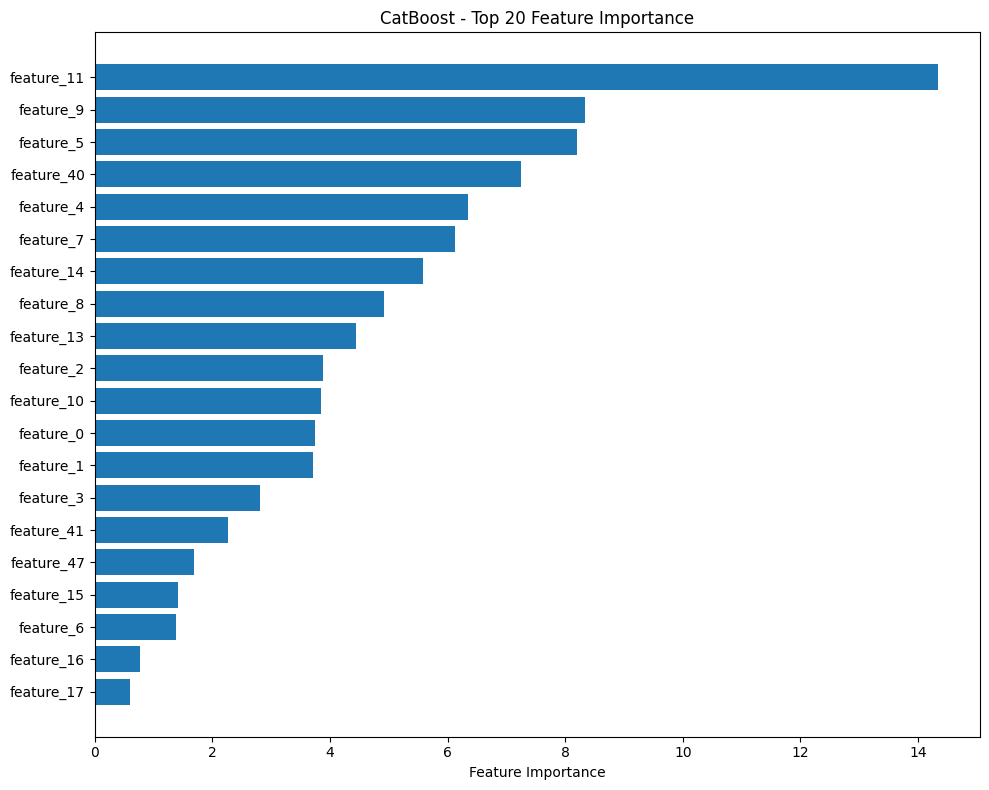

In [49]:

import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, classification_report, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

def calculate_class_weights_catboost(y_train):
    """
    Calculate class weights for CatBoost
    """
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    return class_weight_dict

def train_catboost_model(X_train, y_train, categorical_features=None, verbose=True):
    """
    Train CatBoost classifier with hyperparameter tuning
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    categorical_features : list, optional
        List of categorical feature indices or names
    verbose : bool
        Whether to print training progress
    
    Returns:
    --------
    dict : Dictionary containing trained model and results
    """
    
    # Calculate class weights
    class_weight_dict = calculate_class_weights_catboost(y_train)
    
    # CatBoost model with class balancing
    catboost_model = CatBoostClassifier(
        random_seed=42,
        verbose=0,  # Suppress CatBoost output during training
        class_weights=class_weight_dict,
        cat_features=categorical_features,
        bootstrap_type='Bernoulli'  # Use Bernoulli to enable subsample parameter
    )
    
    # Parameter distribution for RandomizedSearchCV
    catboost_params = {
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),  # Now compatible with Bernoulli bootstrap
        'colsample_bylevel': uniform(0.6, 0.4),
        'reg_lambda': uniform(0, 5),
        'min_data_in_leaf': randint(1, 20),
        'max_leaves': randint(16, 128),
        # Removed bagging_temperature as it's not compatible with Bernoulli bootstrap
    }
    
    # Setup cross-validation
    f1_scorer = make_scorer(f1_score, average='weighted')
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        catboost_model,
        catboost_params,
        n_iter=30,  # Number of parameter combinations to try
        cv=stratified_cv,
        scoring=f1_scorer,
        n_jobs=-1,
        verbose=1 if verbose else 0,
        random_state=42
    )
    
    if verbose:
        print("Training CatBoost classifier...")
        print("This may take a few minutes due to hyperparameter optimization...")
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    if verbose:
        print(f"Best F1-score: {random_search.best_score_:.4f}")
        print(f"Best parameters: {random_search.best_params_}")
    
    return {
        'model': random_search.best_estimator_,
        'random_search': random_search,
        'best_score': random_search.best_score_,
        'best_params': random_search.best_params_,
        'class_weights': class_weight_dict
    }

def find_optimal_thresholds_catboost(model, X_val, y_val, class_names=None):
    """
    Find optimal classification thresholds for CatBoost model
    """
    if class_names is None:
        class_names = np.unique(y_val)
    
    # Get prediction probabilities
    y_proba = model.predict_proba(X_val)
    optimal_thresholds = {}
    
    for i, class_name in enumerate(class_names):
        # Create binary classification for current class vs rest
        y_binary = (y_val == class_name).astype(int)
        
        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_binary, y_proba[:, i])
        
        # Find threshold that maximizes F1 score
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        
        optimal_thresholds[class_name] = {
            'threshold': optimal_threshold,
            'f1_score': f1_scores[optimal_idx],
            'precision': precision[optimal_idx],
            'recall': recall[optimal_idx]
        }
        
        print(f"Class {class_name} - Optimal threshold: {optimal_threshold:.4f}, F1: {f1_scores[optimal_idx]:.4f}")
    
    return optimal_thresholds

def predict_with_thresholds_catboost(model, X_test, thresholds):
    """
    Make predictions using custom thresholds for CatBoost
    """
    y_proba = model.predict_proba(X_test)
    predictions = np.zeros(X_test.shape[0])
    class_names = list(thresholds.keys())
    
    # For each sample, assign class with highest probability above threshold
    for i in range(X_test.shape[0]):
        class_scores = []
        for class_idx, class_name in enumerate(class_names):
            prob = y_proba[i, class_idx]
            threshold = thresholds[class_name]['threshold']
            if prob >= threshold:
                class_scores.append((class_name, prob))
        
        if class_scores:
            # Choose class with highest probability among those above threshold
            predictions[i] = max(class_scores, key=lambda x: x[1])[0]
        else:
            # If no class above threshold, choose highest probability
            predictions[i] = class_names[np.argmax(y_proba[i])]
    
    return predictions.astype(int)

def evaluate_catboost_model(catboost_result, X_val, y_val, X_test, y_test):
    """
    Complete evaluation of CatBoost model with threshold tuning
    """
    model = catboost_result['model']
    
    print("="*50)
    print("CatBoost Classifier Evaluation")
    print("="*50)
    
    # Standard evaluation
    y_pred_standard = model.predict(X_test)
    print("Standard predictions:")
    print(classification_report(y_test, y_pred_standard))
    
    # Threshold tuning evaluation
    print("\nFinding optimal thresholds...")
    optimal_thresholds = find_optimal_thresholds_catboost(model, X_val, y_val)
    
    print("\nPredictions with tuned thresholds:")
    y_pred_tuned = predict_with_thresholds_catboost(model, X_test, optimal_thresholds)
    print(classification_report(y_test, y_pred_tuned))
    
    # Calculate metrics
    standard_f1 = f1_score(y_test, y_pred_standard, average='weighted')
    tuned_f1 = f1_score(y_test, y_pred_tuned, average='weighted')
    
    print(f"\nPerformance Summary:")
    print(f"Standard F1: {standard_f1:.4f}")
    print(f"Tuned F1: {tuned_f1:.4f}")
    print(f"Improvement: {tuned_f1 - standard_f1:.4f}")
    
    # Feature importance (CatBoost specific)
    feature_importance = model.get_feature_importance()
    
    return {
        'model': model,
        'standard_f1': standard_f1,
        'tuned_f1': tuned_f1,
        'thresholds': optimal_thresholds,
        'best_params': catboost_result['best_params'],
        'feature_importance': feature_importance,
        'y_pred_standard': y_pred_standard,
        'y_pred_tuned': y_pred_tuned
    }

def plot_catboost_feature_importance(catboost_result, feature_names=None, top_n=20):
    """
    Plot CatBoost feature importance
    """
    model = catboost_result['model']
    importance = model.get_feature_importance()
    
    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(len(importance))]
    
    # Get top N features
    indices = np.argsort(importance)[::-1][:top_n]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'CatBoost - Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Alternative parameter set without subsample (if you prefer Bayesian bootstrap)
def get_bayesian_bootstrap_params():
    """
    Alternative parameter set for Bayesian bootstrap (default CatBoost)
    """
    return {
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'colsample_bylevel': uniform(0.6, 0.4),
        'reg_lambda': uniform(0, 5),
        'min_data_in_leaf': randint(1, 20),
        'max_leaves': randint(16, 128),
        'bagging_temperature': uniform(0, 1),  # Only works with Bayesian bootstrap
    }

# Usage example:

# Train CatBoost model
catboost_result = train_catboost_model(
    X_train, y_train, 
    categorical_features=None,  # Specify if you have categorical features
    verbose=True
)

# Evaluate the model
evaluation_results = evaluate_catboost_model(
    catboost_result, X_train, y_train, X_test, y_test
)

# Plot feature importance
plot_catboost_feature_importance(
    catboost_result, 
    feature_names=None,  # Your feature names if available
    top_n=20
)

# Access the best model
best_catboost = catboost_result['model']

# Make predictions with tuned thresholds
optimal_thresholds = evaluation_results['thresholds']
predictions = predict_with_thresholds_catboost(best_catboost, X_test, optimal_thresholds)


In [50]:
import joblib

# Save model + thresholds together
joblib.dump({
    'model': evaluation_results['model'],
    'thresholds': evaluation_results['thresholds'],
    'best_params': evaluation_results['best_params']
}, "catboost_credit_model.pkl")


['catboost_credit_model.pkl']

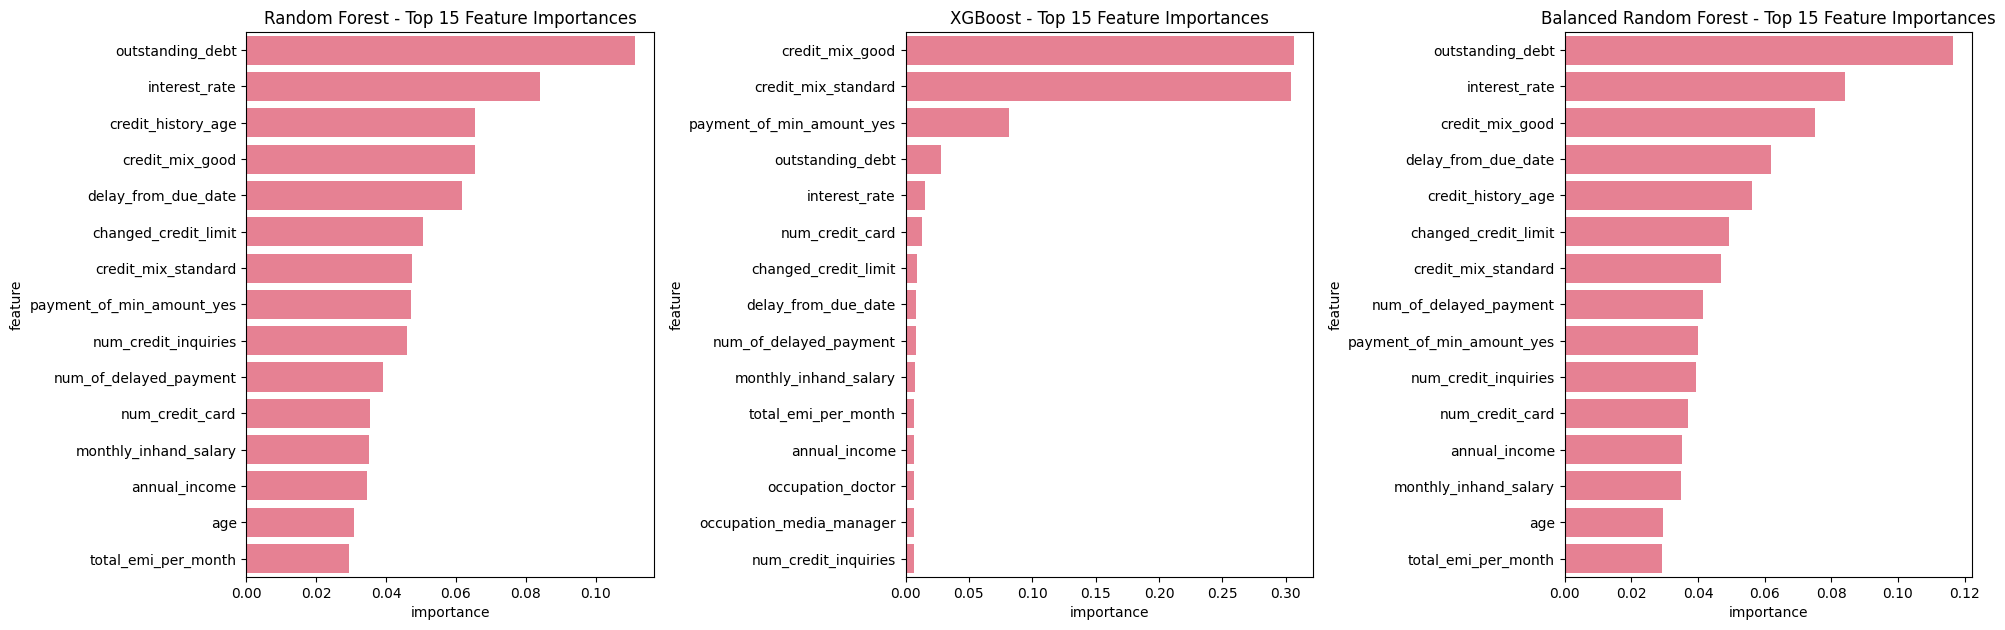

In [51]:
import joblib

# 3. Save the scaler
scaler_filename = f"min_max_scaler.joblib"
joblib.dump(scaler, scaler_filename)
print(f"✅ Saved scaler to {scaler_filename}")

✅ Saved scaler to min_max_scaler.joblib


In [52]:
scaler.feature_names_in_

array(['age', 'num_bank_accounts', 'num_credit_card', 'interest_rate',
       'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment',
       'num_credit_inquiries', 'credit_history_age',
       'credit_utilization_ratio', 'annual_income',
       'monthly_inhand_salary', 'changed_credit_limit',
       'outstanding_debt', 'total_emi_per_month',
       'amount_invested_monthly', 'monthly_balance'], dtype=object)

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, classification_report, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# Calculate class weights for sample weighting
def calculate_class_weights(y_train):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    sample_weights = np.array([class_weight_dict[label] for label in y_train])
    return class_weight_dict, sample_weights

# Option C: Enhanced models with resampling techniques
models = {
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        random_state=42
    ),
    "Balanced Random Forest": BalancedRandomForestClassifier(
        random_state=42,
        sampling_strategy='auto'  # Automatically balance classes
    ),
    "Balanced Bagging RF": BalancedBaggingClassifier(
        estimator=RandomForestClassifier(random_state=42),
        random_state=42,
        sampling_strategy='auto'
    ),
    "Balanced Bagging XGB": BalancedBaggingClassifier(
        estimator=XGBClassifier(random_state=42),
        random_state=42,
        sampling_strategy='auto'
    )
}

# Randomized parameter distributions for faster search
params = {
    "Random Forest": {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 15, 20, 25],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'class_weight': ['balanced', 'balanced_subsample'],
        'bootstrap': [True, False]
    },
    "XGBoost": {
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0.5, 2)
    },
    "Balanced Random Forest": {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 15, 20, 25],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'bootstrap': [True, False]
    },
    "Balanced Bagging RF": {
        'n_estimators': randint(10, 50),  # Number of base estimators
        'estimator__n_estimators': randint(20, 100),  # Trees per base estimator
        'estimator__max_depth': [None, 10, 15, 20],
        'estimator__min_samples_split': randint(2, 15)
    },
    "Balanced Bagging XGB": {
        'n_estimators': randint(10, 50),
        'estimator__learning_rate': uniform(0.01, 0.15),
        'estimator__n_estimators': randint(20, 100),
        'estimator__max_depth': randint(3, 8),
        'estimator__subsample': uniform(0.6, 0.4)
    }
}

# Setup RandomizedSearchCV instead of GridSearchCV
f1_scorer = make_scorer(f1_score, average='weighted')
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_searches = {}
for model_name, model in models.items():
    random_search = RandomizedSearchCV(
        model,
        params[model_name],
        n_iter=20,  # Number of parameter settings sampled (adjust based on time constraints)
        cv=stratified_cv,
        scoring=f1_scorer,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    random_searches[model_name] = random_search

# Training function with sample weights for XGBoost models
def train_models(X_train, y_train):
    class_weight_dict, sample_weights = calculate_class_weights(y_train)
    trained_models = {}

    for model_name, random_search in random_searches.items():
        print(f"\nTraining {model_name}...")

        if "XGBoost" in model_name and "Balanced Bagging" not in model_name:
            # Direct XGBoost model needs sample weights
            random_search.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            # Other models handle imbalance internally or through imblearn
            random_search.fit(X_train, y_train)

        trained_models[model_name] = random_search
        print(f"Best F1-score for {model_name}: {random_search.best_score_:.4f}")
        print(f"Best parameters for {model_name}: {random_search.best_params_}")

    return trained_models

# Option A: Threshold Tuning Functions
def find_optimal_thresholds(model, X_val, y_val, class_names=None):
    """
    Find optimal classification thresholds for each class using precision-recall curves
    """
    if class_names is None:
        class_names = [0, 1, 2]

    # Get prediction probabilities
    y_proba = model.predict_proba(X_val)
    optimal_thresholds = {}

    for i, class_name in enumerate(class_names):
        # Create binary classification for current class vs rest
        y_binary = (y_val == class_name).astype(int)

        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_binary, y_proba[:, i])

        # Find threshold that maximizes F1 score
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

        optimal_thresholds[class_name] = {
            'threshold': optimal_threshold,
            'f1_score': f1_scores[optimal_idx],
            'precision': precision[optimal_idx],
            'recall': recall[optimal_idx]
        }

        print(f"Class {class_name} - Optimal threshold: {optimal_threshold:.4f}, F1: {f1_scores[optimal_idx]:.4f}")

    return optimal_thresholds

def predict_with_thresholds(model, X_test, thresholds):
    """
    Make predictions using custom thresholds
    """
    y_proba = model.predict_proba(X_test)
    predictions = np.zeros(X_test.shape[0])

    # For each sample, assign class with highest probability above threshold
    for i in range(X_test.shape[0]):
        class_scores = []
        for class_idx, class_name in enumerate([0, 1, 2]):
            prob = y_proba[i, class_idx]
            threshold = thresholds[class_name]['threshold']
            if prob >= threshold:
                class_scores.append((class_name, prob))

        if class_scores:
            # Choose class with highest probability among those above threshold
            predictions[i] = max(class_scores, key=lambda x: x[1])[0]
        else:
            # If no class above threshold, choose highest probability
            predictions[i] = np.argmax(y_proba[i])

    return predictions.astype(int)

def plot_threshold_analysis(model, X_val, y_val, class_names=None):
    """
    Plot precision-recall curves for threshold analysis
    """
    if class_names is None:
        class_names = [0, 1, 2]

    y_proba = model.predict_proba(X_val)

    plt.figure(figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        plt.subplot(1, 3, i+1)

        y_binary = (y_val == class_name).astype(int)
        precision, recall, thresholds = precision_recall_curve(y_binary, y_proba[:, i])

        # Calculate F1 scores
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)

        plt.plot(recall, precision, label=f'Class {class_name}')
        plt.scatter(recall[optimal_idx], precision[optimal_idx],
                   color='red', s=100, label=f'Optimal (F1={f1_scores[optimal_idx]:.3f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - Class {class_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Complete evaluation function
def evaluate_with_threshold_tuning(trained_models, X_val, y_val, X_test, y_test):
    """
    Evaluate all models with and without threshold tuning
    """
    results = {}

    for model_name, random_search in trained_models.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {model_name}")
        print(f"{'='*50}")

        best_model = random_search.best_estimator_

        # Standard evaluation
        y_pred_standard = best_model.predict(X_test)
        print("Standard predictions:")
        print(classification_report(y_test, y_pred_standard))

        # Threshold tuning evaluation
        print("\nFinding optimal thresholds...")
        optimal_thresholds = find_optimal_thresholds(best_model, X_val, y_val)

        print("\nPredictions with tuned thresholds:")
        y_pred_tuned = predict_with_thresholds(best_model, X_test, optimal_thresholds)
        print(classification_report(y_test, y_pred_tuned))

        # Store results
        results[model_name] = {
            'model': best_model,
            'standard_f1': f1_score(y_test, y_pred_standard, average='weighted'),
            'tuned_f1': f1_score(y_test, y_pred_tuned, average='weighted'),
            'thresholds': optimal_thresholds,
            'best_params': random_search.best_params_
        }

        print(f"Standard F1: {results[model_name]['standard_f1']:.4f}")
        print(f"Tuned F1: {results[model_name]['tuned_f1']:.4f}")
        print(f"Improvement: {results[model_name]['tuned_f1'] - results[model_name]['standard_f1']:.4f}")

    return results

# Usage examples for your customer-based split:

# OPTION 1: Use cross-validation for threshold tuning (Recommended - simpler)

# Train all models
trained_models = train_models(X_train, y_train)

# Evaluate with CV-based threshold tuning
results = evaluate_with_threshold_tuning(
    trained_models, X_train, y_train, X_test, y_test
)

# Get best model
best_model_name = max(results.keys(), key=lambda k: results[k]['tuned_f1'])
print(f"\nBest model: {best_model_name}")
print(f"Best tuned F1 score: {results[best_model_name]['tuned_f1']:.4f}")




Evaluating Random Forest
Standard predictions:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      5891
           1       0.55      0.78      0.65      3664
           2       0.78      0.68      0.73     10445

    accuracy                           0.70     20000
   macro avg       0.68      0.72      0.69     20000
weighted avg       0.72      0.70      0.71     20000


Finding optimal thresholds...
Class 0 - Optimal threshold: 0.6762, F1: 0.9528
Class 1 - Optimal threshold: 0.6929, F1: 0.9501
Class 2 - Optimal threshold: 0.2981, F1: 0.9603

Predictions with tuned thresholds:
              precision    recall  f1-score   support

           0       0.78      0.59      0.67      5891
           1       0.62      0.49      0.55      3664
           2       0.69      0.83      0.75     10445

    accuracy                           0.70     20000
   macro avg       0.70      0.64      0.66     20000
weighted avg       0.70      0.70 

Training Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best F1-score for Random Forest: 0.8156
Best parameters for Random Forest: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}

Training XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best F1-score for XGBoost: 0.8066
Best parameters for XGBoost: {'colsample_bytree': np.float64(0.9757995766256756), 'learning_rate': np.float64(0.18896547008552977), 'max_depth': 8, 'n_estimators': 144, 'reg_alpha': np.float64(0.9218742350231168), 'reg_lambda': np.float64(0.676985004103839), 'subsample': np.float64(0.6783931449676581)}

Training Balanced Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best F1-score for Balanced Random Forest: 0.7927
Best parameters for Balanced Random Forest: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 139}

Training Balanced Bagging RF...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best F1-score for Balanced Bagging RF: 0.7971
Best parameters for Balanced Bagging RF: {'estimator__max_depth': None, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 26, 'n_estimators': 30}

Training Balanced Bagging XGB...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best F1-score for Balanced Bagging XGB: 0.7417
Best parameters for Balanced Bagging XGB: {'estimator__learning_rate': np.float64(0.13899106101044809), 'estimator__max_depth': 7, 'estimator__n_estimators': 92, 'estimator__subsample': np.float64(0.6260206371941118), 'n_estimators': 13}

In [23]:
# trained_models

Starting complete model evaluation...

Training and Evaluating Random Forest
F1 Score (Weighted): 0.7050
F1 Score (Macro): 0.6909

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      5891
           1       0.55      0.78      0.65      3664
           2       0.78      0.68      0.73     10445

    accuracy                           0.70     20000
   macro avg       0.68      0.72      0.69     20000
weighted avg       0.72      0.70      0.71     20000



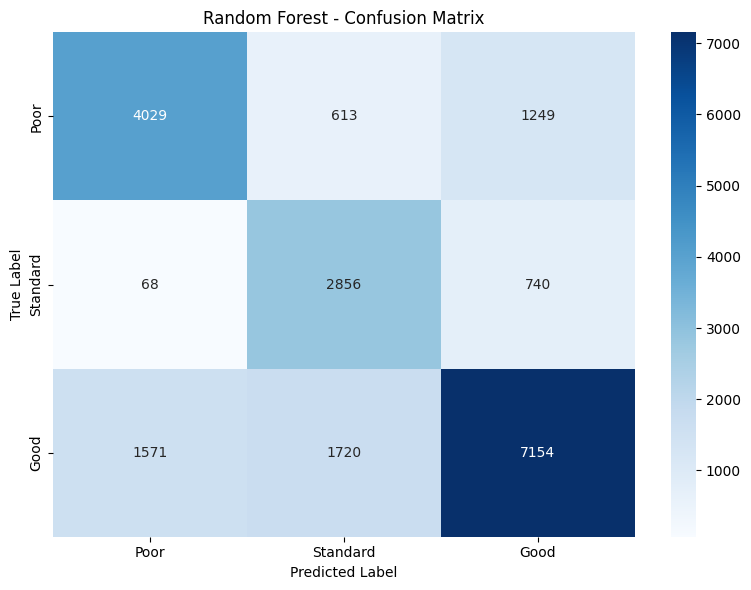


Training and Evaluating XGBoost
F1 Score (Weighted): 0.6962
F1 Score (Macro): 0.6706

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69      5891
           1       0.61      0.56      0.58      3664
           2       0.71      0.77      0.74     10445

    accuracy                           0.70     20000
   macro avg       0.68      0.66      0.67     20000
weighted avg       0.70      0.70      0.70     20000



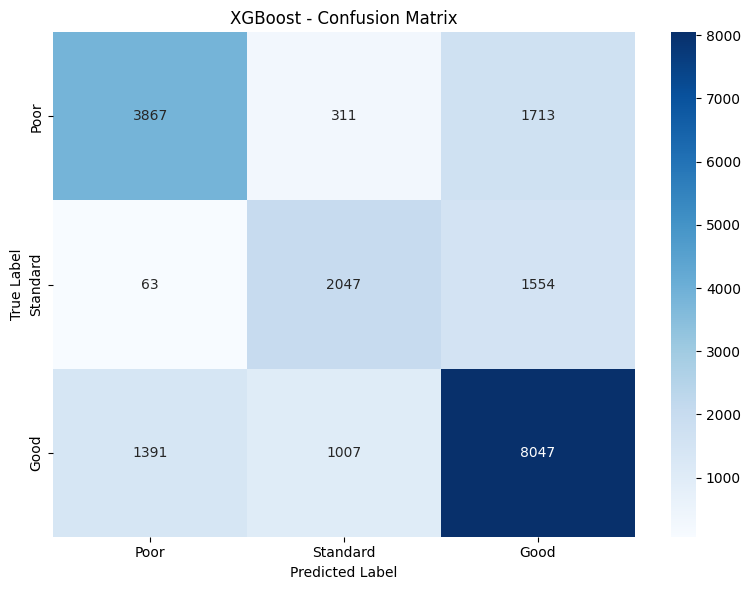


Training and Evaluating Balanced Random Forest
F1 Score (Weighted): 0.6964
F1 Score (Macro): 0.6873

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70      5891
           1       0.54      0.83      0.65      3664
           2       0.82      0.62      0.71     10445

    accuracy                           0.69     20000
   macro avg       0.68      0.73      0.69     20000
weighted avg       0.73      0.69      0.70     20000



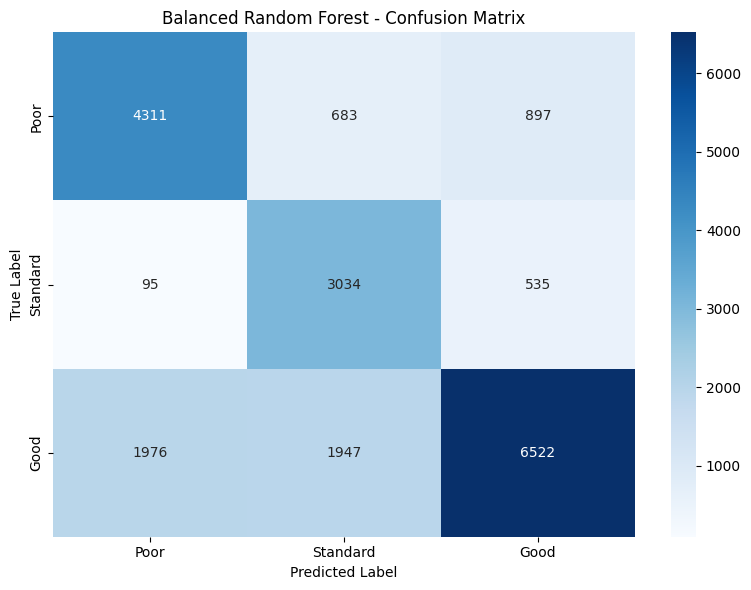


Training and Evaluating Balanced Bagging RF
F1 Score (Weighted): 0.6959
F1 Score (Macro): 0.6870

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.71      5891
           1       0.53      0.84      0.65      3664
           2       0.83      0.62      0.71     10445

    accuracy                           0.69     20000
   macro avg       0.68      0.73      0.69     20000
weighted avg       0.73      0.69      0.70     20000



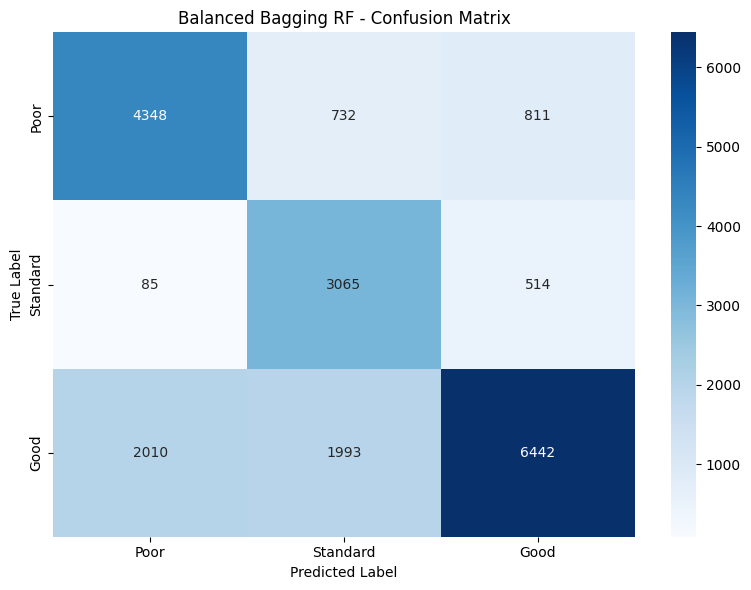


Training and Evaluating Balanced Bagging XGB
F1 Score (Weighted): 0.6947
F1 Score (Macro): 0.6859

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      5891
           1       0.53      0.83      0.65      3664
           2       0.82      0.62      0.71     10445

    accuracy                           0.69     20000
   macro avg       0.68      0.73      0.69     20000
weighted avg       0.73      0.69      0.69     20000



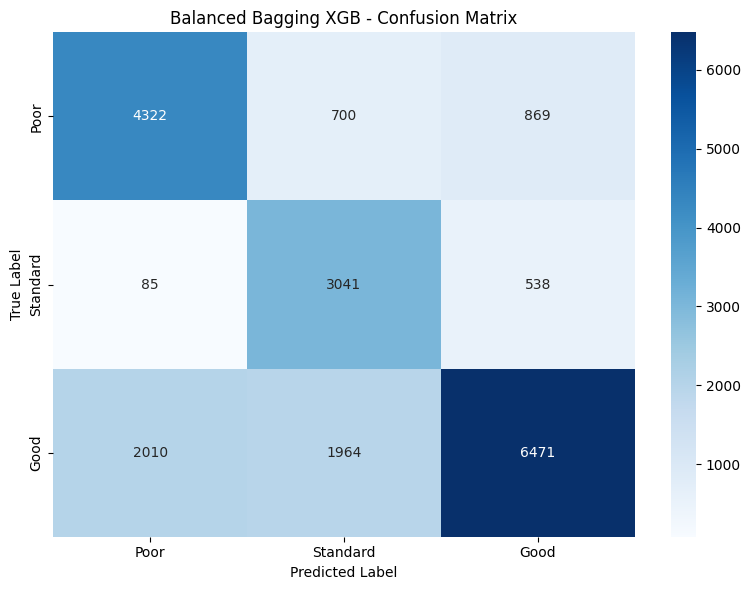


FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 10 Features:
outstanding_debt: 0.1112
interest_rate: 0.0841
credit_history_age: 0.0655
credit_mix_good: 0.0653
delay_from_due_date: 0.0617
changed_credit_limit: 0.0507
credit_mix_standard: 0.0474
payment_of_min_amount_yes: 0.0471
num_credit_inquiries: 0.0459
num_of_delayed_payment: 0.0390

XGBoost - Top 10 Features:
credit_mix_good: 0.3064
credit_mix_standard: 0.3042
payment_of_min_amount_yes: 0.0815
outstanding_debt: 0.0283
interest_rate: 0.0156
num_credit_card: 0.0132
changed_credit_limit: 0.0088
delay_from_due_date: 0.0084
num_of_delayed_payment: 0.0081
monthly_inhand_salary: 0.0074

Balanced Random Forest - Top 10 Features:
outstanding_debt: 0.1165
interest_rate: 0.0840
credit_mix_good: 0.0750
delay_from_due_date: 0.0618
credit_history_age: 0.0561
changed_credit_limit: 0.0493
credit_mix_standard: 0.0470
num_of_delayed_payment: 0.0414
payment_of_min_amount_yes: 0.0399
num_credit_inquiries: 0.0393


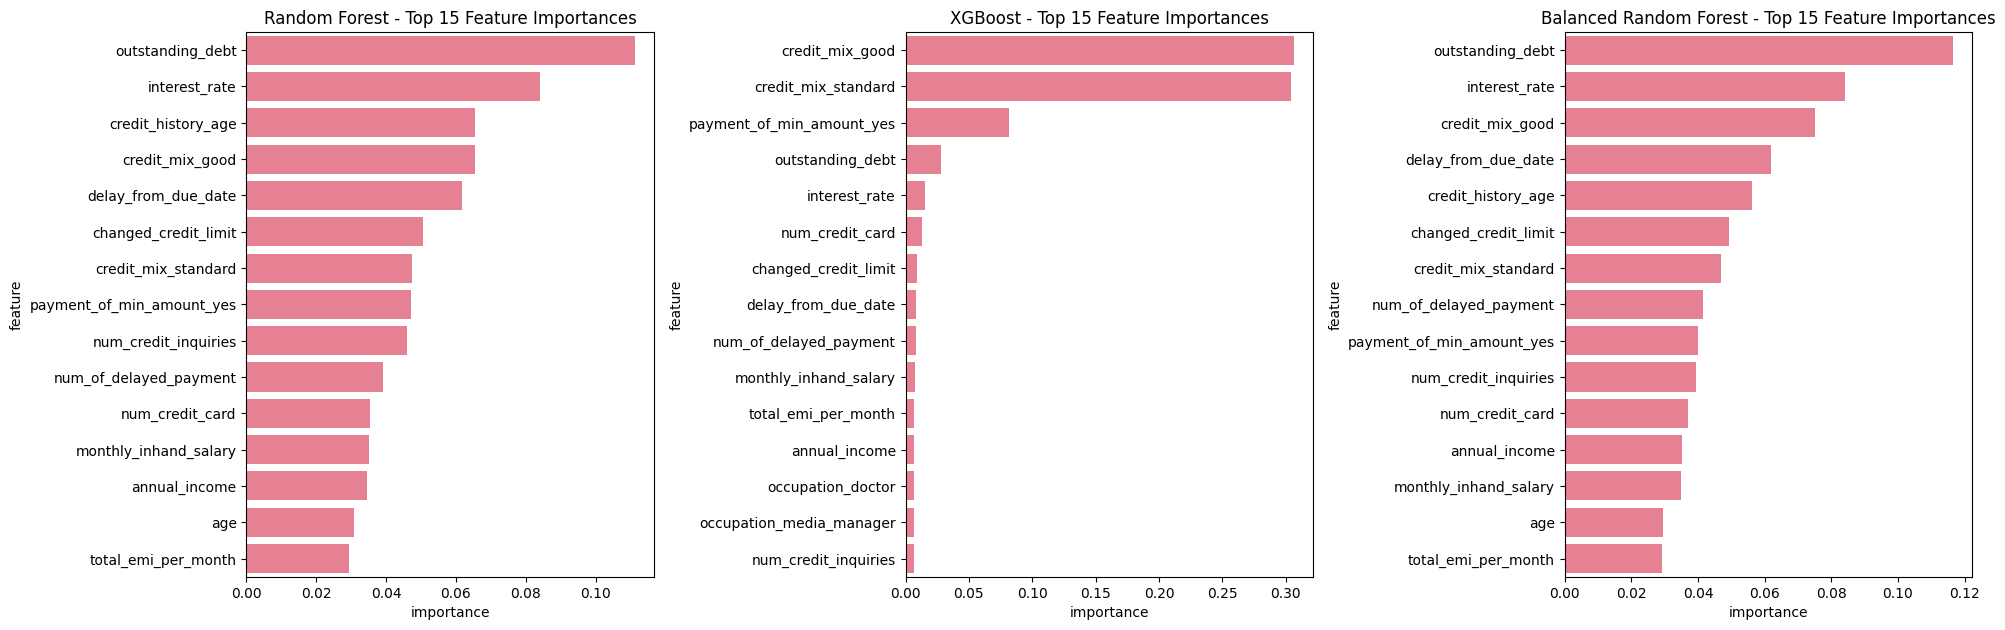


THRESHOLD TUNING EVALUATION

--------------------------------------------------
Threshold tuning for Random Forest
--------------------------------------------------
Finding optimal thresholds using cross-validation...
Class 0: Threshold=0.3277, F1=0.6968
Class 1: Threshold=0.3417, F1=0.6286
Class 2: Threshold=0.3299, F1=0.7460
Original F1: 0.7050
Threshold F1: 0.7051
Improvement: 0.0001

Threshold-tuned Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      5891
           1       0.55      0.78      0.65      3664
           2       0.78      0.69      0.73     10445

    accuracy                           0.70     20000
   macro avg       0.68      0.72      0.69     20000
weighted avg       0.72      0.70      0.71     20000


--------------------------------------------------
Threshold tuning for XGBoost
--------------------------------------------------
Finding optimal thresholds using cross-validation...
Cl

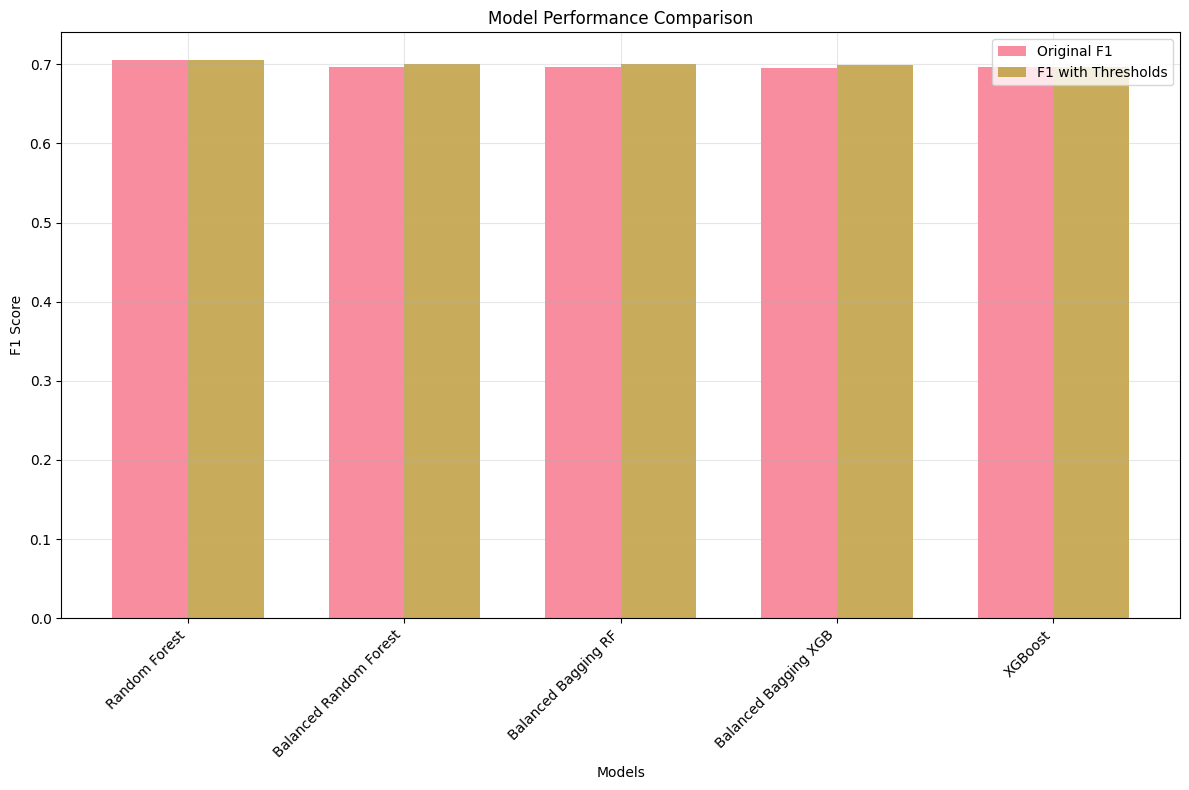


FINAL RECOMMENDATION
Best Model: Random Forest
Best F1 Score: 0.7051
Improvement over baseline: 0.0001


In [25]:
# Complete Model Evaluation Code
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Create models with your best parameters
best_models = {
    "Random Forest": RandomForestClassifier(
        bootstrap=False,
        class_weight='balanced_subsample',
        max_depth=None,
        min_samples_leaf=3,
        min_samples_split=6,
        n_estimators=100,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        colsample_bytree=0.9757995766256756,
        learning_rate=0.18896547008552977,
        max_depth=8,
        n_estimators=144,
        reg_alpha=0.9218742350231168,
        reg_lambda=0.676985004103839,
        subsample=0.6783931449676581,
        random_state=42
    ),

    "Balanced Random Forest": BalancedRandomForestClassifier(
        bootstrap=False,
        max_depth=None,
        min_samples_leaf=2,
        min_samples_split=10,
        n_estimators=139,
        random_state=42
    ),

    "Balanced Bagging RF": BalancedBaggingClassifier(
        estimator=RandomForestClassifier(
            max_depth=None,
            min_samples_split=4,
            n_estimators=26,
            random_state=42
        ),
        n_estimators=30,
        random_state=42
    ),

    "Balanced Bagging XGB": BalancedBaggingClassifier(
        estimator=XGBClassifier(
            learning_rate=0.13899106101044809,
            max_depth=7,
            n_estimators=92,
            subsample=0.6260206371941118,
            random_state=42
        ),
        n_estimators=13,
        random_state=42
    )
}

# Train all models and store results
def train_and_evaluate_all_models(X_train, y_train, X_test, y_test):
    """
    Train all models with best parameters and evaluate them
    """
    results = {}
    trained_models = {}

    for model_name, model in best_models.items():
        print(f"\n{'='*60}")
        print(f"Training and Evaluating {model_name}")
        print(f"{'='*60}")

        # Train the model
        model.fit(X_train, y_train)
        trained_models[model_name] = model

        # Make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        # Calculate metrics
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        f1_macro = f1_score(y_test, y_pred, average='macro')

        # Store results
        results[model_name] = {
            'model': model,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }

        # Print results
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"F1 Score (Macro): {f1_macro:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Poor', 'Standard', 'Good'],
                    yticklabels=['Poor', 'Standard', 'Good'])
        plt.title(f'{model_name} - Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    return results, trained_models

# Feature importance analysis for tree-based models
def analyze_feature_importance(trained_models, feature_names, top_n=15):
    """
    Analyze and plot feature importance for models that support it
    """
    plt.figure(figsize=(20, 12))
    subplot_idx = 1

    for model_name, model in trained_models.items():
        if hasattr(model, 'feature_importances_'):
            plt.subplot(2, 3, subplot_idx)

            # Get feature importance
            if hasattr(model, 'estimators_') and hasattr(model, 'feature_importances_'):
                # For ensemble methods like BalancedBaggingClassifier
                importance = model.feature_importances_
            else:
                # For direct models
                importance = model.feature_importances_

            # Create dataframe
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False).head(top_n)

            # Plot
            sns.barplot(data=importance_df, y='feature', x='importance')
            plt.title(f'{model_name} - Top {top_n} Feature Importances')
            plt.tight_layout()

            subplot_idx += 1

            # Print top 10 features
            print(f"\n{model_name} - Top 10 Features:")
            for idx, row in importance_df.head(10).iterrows():
                print(f"{row['feature']}: {row['importance']:.4f}")

    plt.tight_layout()
    plt.show()

# Fixed threshold tuning function
def find_optimal_thresholds_fixed(model, X_train, y_train, cv_folds=3):
    """
    Find optimal thresholds using cross-validation (fixed version)
    """
    from sklearn.model_selection import cross_val_predict

    print("Finding optimal thresholds using cross-validation...")

    # Get cross-validated predictions
    try:
        y_proba_cv = cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict_proba')
    except Exception as e:
        print(f"Cross-validation failed: {e}")
        print("Using direct fit on training data...")
        model_temp = type(model)(**model.get_params())
        model_temp.fit(X_train, y_train)
        y_proba_cv = model_temp.predict_proba(X_train)

    optimal_thresholds = {}
    class_names = [0, 1, 2]

    for i, class_name in enumerate(class_names):
        # Binary classification for current class
        y_binary = (y_train == class_name).astype(int)

        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_binary, y_proba_cv[:, i])

        # Find optimal threshold (maximize F1)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        optimal_idx = np.argmax(f1_scores)

        if optimal_idx < len(thresholds):
            optimal_threshold = thresholds[optimal_idx]
        else:
            optimal_threshold = 0.5

        optimal_thresholds[class_name] = {
            'threshold': optimal_threshold,
            'f1_score': f1_scores[optimal_idx],
            'precision': precision[optimal_idx],
            'recall': recall[optimal_idx]
        }

        print(f"Class {class_name}: Threshold={optimal_threshold:.4f}, F1={f1_scores[optimal_idx]:.4f}")

    return optimal_thresholds

def predict_with_thresholds_fixed(model, X_test, thresholds):
    """
    Make predictions using custom thresholds (fixed version)
    """
    y_proba = model.predict_proba(X_test)
    predictions = []

    for i in range(X_test.shape[0]):
        class_scores = []

        for class_idx in [0, 1, 2]:
            prob = y_proba[i, class_idx]
            threshold = thresholds[class_idx]['threshold']

            if prob >= threshold:
                class_scores.append((class_idx, prob))

        if class_scores:
            # Choose class with highest probability among those above threshold
            predicted_class = max(class_scores, key=lambda x: x[1])[0]
        else:
            # If no class above threshold, choose highest probability
            predicted_class = np.argmax(y_proba[i])

        predictions.append(predicted_class)

    return np.array(predictions)

# Complete evaluation with threshold tuning
def complete_evaluation_with_thresholds(results, trained_models, X_train, y_train, X_test, y_test):
    """
    Complete evaluation including threshold tuning for all models
    """
    print(f"\n{'='*80}")
    print("THRESHOLD TUNING EVALUATION")
    print(f"{'='*80}")

    threshold_results = {}

    for model_name, model in trained_models.items():
        print(f"\n{'-'*50}")
        print(f"Threshold tuning for {model_name}")
        print(f"{'-'*50}")

        try:
            # Find optimal thresholds
            optimal_thresholds = find_optimal_thresholds_fixed(model, X_train, y_train)

            # Make predictions with thresholds
            y_pred_threshold = predict_with_thresholds_fixed(model, X_test, optimal_thresholds)

            # Calculate metrics
            f1_threshold = f1_score(y_test, y_pred_threshold, average='weighted')
            f1_original = results[model_name]['f1_weighted']
            improvement = f1_threshold - f1_original

            threshold_results[model_name] = {
                'original_f1': f1_original,
                'threshold_f1': f1_threshold,
                'improvement': improvement,
                'thresholds': optimal_thresholds
            }

            print(f"Original F1: {f1_original:.4f}")
            print(f"Threshold F1: {f1_threshold:.4f}")
            print(f"Improvement: {improvement:.4f}")

            print("\nThreshold-tuned Classification Report:")
            print(classification_report(y_test, y_pred_threshold))

        except Exception as e:
            print(f"Threshold tuning failed for {model_name}: {e}")
            threshold_results[model_name] = {
                'original_f1': results[model_name]['f1_weighted'],
                'threshold_f1': results[model_name]['f1_weighted'],
                'improvement': 0,
                'thresholds': None
            }

    return threshold_results

# Summary comparison function
def create_model_comparison_summary(results, threshold_results):
    """
    Create a comprehensive comparison summary
    """
    print(f"\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")

    comparison_data = []

    for model_name in results.keys():
        comparison_data.append({
            'Model': model_name,
            'Original F1 (Weighted)': results[model_name]['f1_weighted'],
            'F1 with Thresholds': threshold_results[model_name]['threshold_f1'],
            'Improvement': threshold_results[model_name]['improvement'],
            'F1 (Macro)': results[model_name]['f1_macro']
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1 with Thresholds', ascending=False)

    print(comparison_df.to_string(index=False, float_format='{:.4f}'.format))

    # Plot comparison
    plt.figure(figsize=(12, 8))

    x = range(len(comparison_df))
    width = 0.35

    plt.bar([i - width/2 for i in x], comparison_df['Original F1 (Weighted)'],
            width, label='Original F1', alpha=0.8)
    plt.bar([i + width/2 for i in x], comparison_df['F1 with Thresholds'],
            width, label='F1 with Thresholds', alpha=0.8)

    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, comparison_df['Model'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return comparison_df

# Main execution function
def run_complete_evaluation(X_train, y_train, X_test, y_test, feature_names):
    """
    Run the complete evaluation pipeline
    """
    print("Starting complete model evaluation...")

    # 1. Train and evaluate all models
    results, trained_models = train_and_evaluate_all_models(X_train, y_train, X_test, y_test)

    # 2. Feature importance analysis
    print(f"\n{'='*80}")
    print("FEATURE IMPORTANCE ANALYSIS")
    print(f"{'='*80}")
    analyze_feature_importance(trained_models, feature_names)

    # 3. Threshold tuning evaluation
    threshold_results = complete_evaluation_with_thresholds(
        results, trained_models, X_train, y_train, X_test, y_test
    )

    # 4. Final comparison
    comparison_df = create_model_comparison_summary(results, threshold_results)

    # 5. Best model selection
    best_model_name = comparison_df.iloc[0]['Model']
    best_model = trained_models[best_model_name]

    print(f"\n{'='*80}")
    print("FINAL RECOMMENDATION")
    print(f"{'='*80}")
    print(f"Best Model: {best_model_name}")
    print(f"Best F1 Score: {comparison_df.iloc[0]['F1 with Thresholds']:.4f}")
    print(f"Improvement over baseline: {comparison_df.iloc[0]['Improvement']:.4f}")

    return {
        'results': results,
        'trained_models': trained_models,
        'threshold_results': threshold_results,
        'comparison_df': comparison_df,
        'best_model_name': best_model_name,
        'best_model': best_model
    }

# Usage:
# Run the complete evaluation
evaluation_results = run_complete_evaluation(X_train, y_train, X_test, y_test, X_train.columns.tolist())

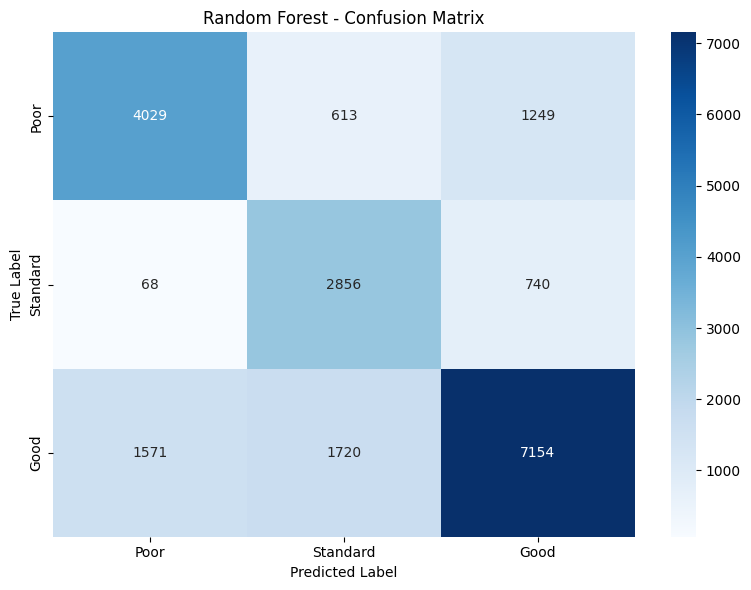

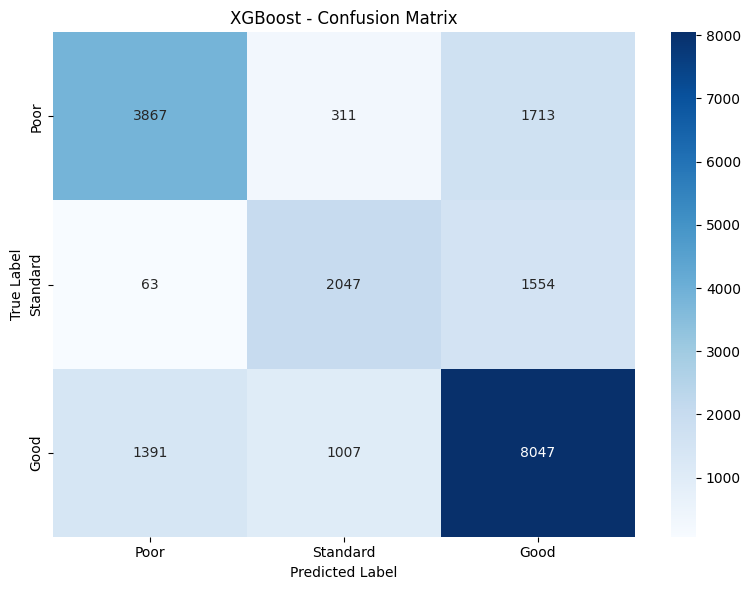

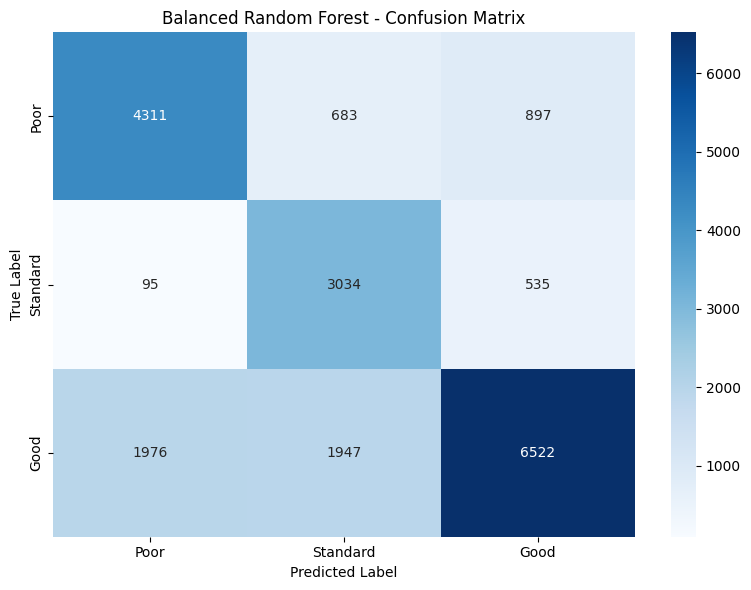

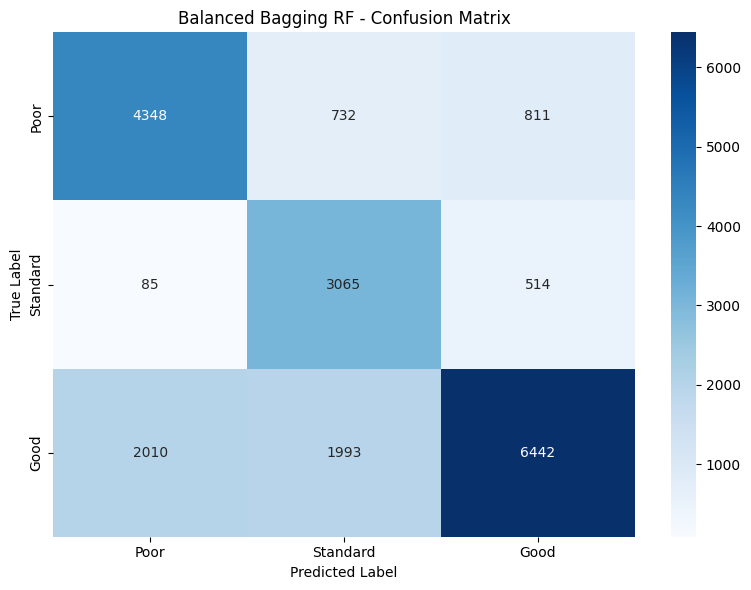

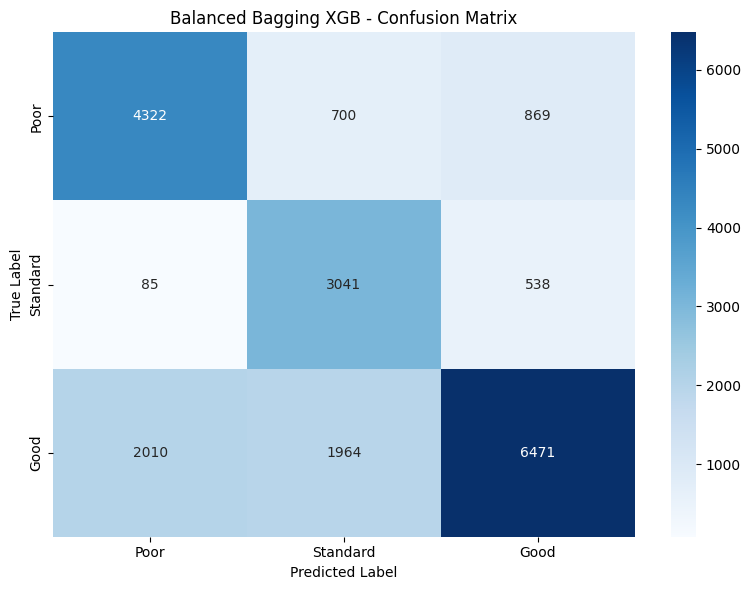

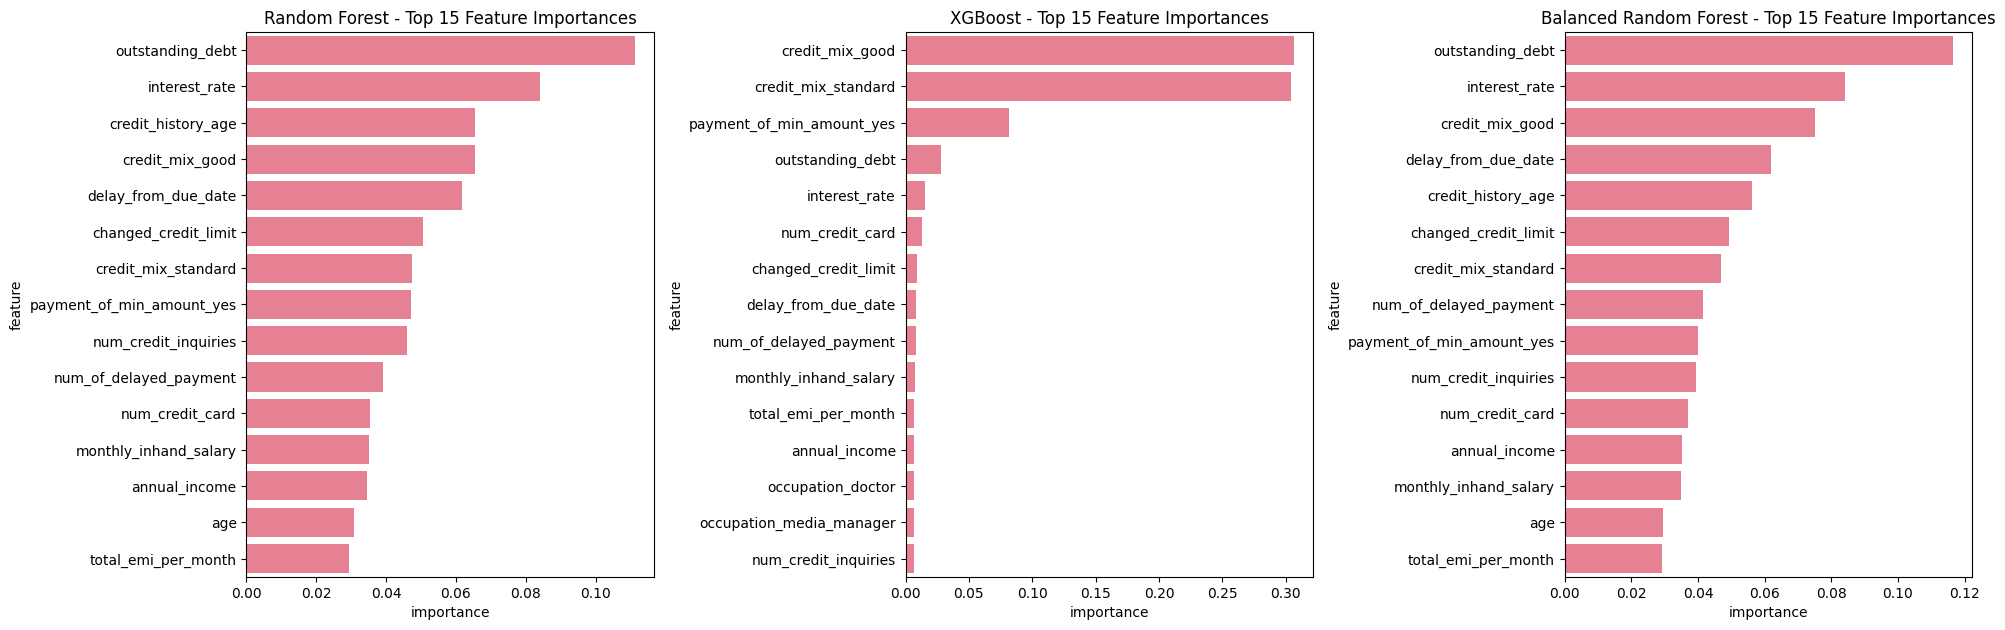

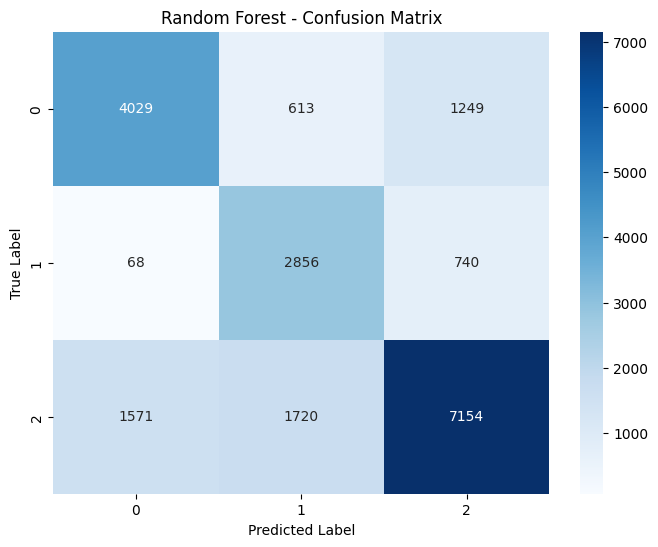

Final Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70      5891
           1       0.55      0.78      0.65      3664
           2       0.78      0.68      0.73     10445

    accuracy                           0.70     20000
   macro avg       0.68      0.72      0.69     20000
weighted avg       0.72      0.70      0.71     20000



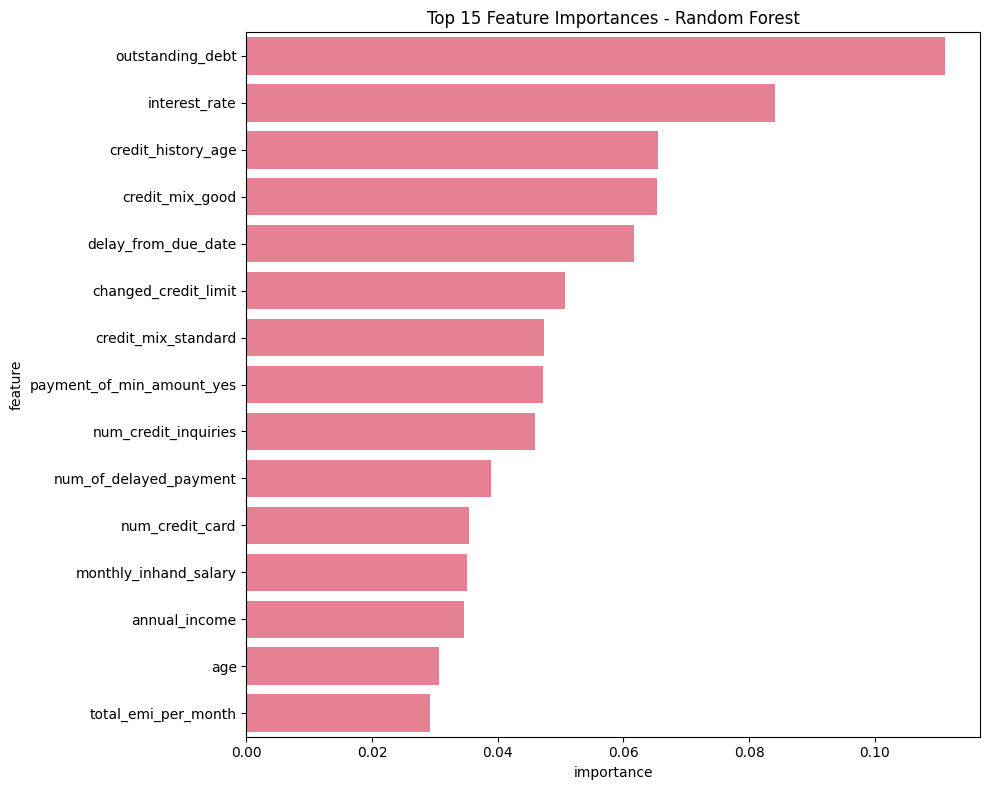

In [30]:
# 1. Get final model performance with threshold tuning
# trained_models = train_models(X_train, y_train)
# results = evaluate_with_threshold_tuning(
#     trained_models, X_train, y_train, X_test, y_test
# )

# 2. Focus on Random Forest (your best model)
best_rf_model = trained_models['Random Forest'].best_estimator_

# 3. Generate comprehensive evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
y_pred_rf = best_rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("Final Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

In [31]:
# Save all necessary artifacts for production
import joblib
import pickle
from datetime import datetime

# Create timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save the best model
model_filename = f"best_rf_model_{timestamp}.joblib"
joblib.dump(best_rf_model, model_filename)

# 2. Save the scaler
scaler_filename = f"feature_scaler_{timestamp}.joblib"
joblib.dump(scaler, scaler_filename)

# 3. Save processed dataframe (for reference and validation)
processed_df_filename = f"processed_data_{timestamp}.pkl"
processed_df.to_pickle(processed_df_filename)

# 4. Save feature names and model metadata
model_metadata = {
    'model_type': 'RandomForestClassifier',
    'best_params': trained_models['Random Forest'].best_params_,
    'f1_score': results['Random Forest']['standard_f1'],
    'tuned_f1_score': results['Random Forest']['tuned_f1'],
    'feature_names': list(X_train.columns),
    'numerical_columns': numerical_columns,  # Your numerical columns list
    'target_classes': [0, 1, 2],
    'class_names': ['Poor', 'Standard', 'Good'],  # Adjust based on your mapping
    'training_date': timestamp,
    'optimal_thresholds': results['Random Forest']['thresholds'] if 'thresholds' in results['Random Forest'] else None
}

metadata_filename = f"model_metadata_{timestamp}.pkl"
with open(metadata_filename, 'wb') as f:
    pickle.dump(model_metadata, f)

# 5. Create requirements.txt for the model
model_requirements = """
scikit-learn==1.3.0
pandas==2.0.3
numpy==1.24.3
joblib==1.3.1
"""

with open('model_requirements.txt', 'w') as f:
    f.write(model_requirements)

print("All model artifacts saved successfully!")
print(f"Files created:")
print(f"- {model_filename}")
print(f"- {scaler_filename}")
print(f"- {processed_df_filename}")
print(f"- {metadata_filename}")
print("- model_requirements.txt")

All model artifacts saved successfully!
Files created:
- best_rf_model_20250906_181101.joblib
- feature_scaler_20250906_181101.joblib
- processed_data_20250906_181101.pkl
- model_metadata_20250906_181101.pkl
- model_requirements.txt


In [32]:
# Create a prediction function for production use
def predict_credit_score(new_data, model, scaler, feature_names, numerical_columns, metadata=None):
    """
    Production-ready prediction function

    Args:
        new_data: DataFrame with same structure as training data (without target)
        model: Trained RandomForest model
        scaler: Fitted StandardScaler
        feature_names: List of feature names used in training
        numerical_columns: List of numerical column names
        metadata: Model metadata dictionary

    Returns:
        Dictionary with predictions and probabilities
    """
    import pandas as pd
    import numpy as np

    # Ensure same feature order
    new_data_processed = new_data[feature_names].copy()

    # Apply scaling to numerical features
    new_data_processed[numerical_columns] = scaler.transform(new_data_processed[numerical_columns])

    # Make predictions
    predictions = model.predict(new_data_processed)
    probabilities = model.predict_proba(new_data_processed)

    # Format results
    results = []
    class_names = ['Poor', 'Standard', 'Good']  # Adjust based on your mapping

    for i in range(len(predictions)):
        result = {
            'predicted_class': int(predictions[i]),
            'predicted_label': class_names[predictions[i]],
            'confidence': float(probabilities[i].max()),
            'probabilities': {
                'Poor': float(probabilities[i][0]),
                'Standard': float(probabilities[i][1]),
                'Good': float(probabilities[i][2])
            }
        }
        results.append(result)

    return results

# Test the prediction function
sample_data = X_test.iloc[:5].copy()  # Test with first 5 rows
test_predictions = predict_credit_score(
    sample_data, best_rf_model, scaler,
    list(X_train.columns), numerical_columns, model_metadata
)

print("Sample predictions:")
for i, pred in enumerate(test_predictions):
    print(f"Sample {i+1}: {pred}")

Sample predictions:
Sample 1: {'predicted_class': 1, 'predicted_label': 'Standard', 'confidence': 0.43925576424901647, 'probabilities': {'Poor': 0.20703527867245633, 'Standard': 0.43925576424901647, 'Good': 0.3537089570785271}}
Sample 2: {'predicted_class': 1, 'predicted_label': 'Standard', 'confidence': 0.46784318015872084, 'probabilities': {'Poor': 0.1885625699067419, 'Standard': 0.46784318015872084, 'Good': 0.34359424993453735}}
Sample 3: {'predicted_class': 1, 'predicted_label': 'Standard', 'confidence': 0.46784318015872084, 'probabilities': {'Poor': 0.1885625699067419, 'Standard': 0.46784318015872084, 'Good': 0.34359424993453735}}
Sample 4: {'predicted_class': 1, 'predicted_label': 'Standard', 'confidence': 0.47032185725996506, 'probabilities': {'Poor': 0.1885625699067419, 'Standard': 0.47032185725996506, 'Good': 0.341115572833293}}
Sample 5: {'predicted_class': 1, 'predicted_label': 'Standard', 'confidence': 0.43925576424901647, 'probabilities': {'Poor': 0.20703527867245633, 'Sta



---



In [32]:
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

params = {
    "Random Forest": {
        'n_estimators': [16, 32, 64, 128],
        'max_depth': [None, 10, 20],
       # 'min_samples_split': [5, 10],
        #'min_samples_leaf': [2, 5],
        #'bootstrap': [True, False],
    },
    "XGBoost": {
        'learning_rate': [0.1, 0.05, 0.001],
        'n_estimators': [16, 32, 64, 128],
        #'max_depth': [3, 4, 5],
        'subsample': [0.7, 0.8]
    }
}

f1_scorer = make_scorer(f1_score, average='weighted')

grid_searches = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(
        model,
        params[model_name],
        cv=3,  # Use the number of desired cross-validation folds
        scoring=f1_scorer,
        n_jobs=-1,  # Use all available CPU cores
        verbose=2,
    )
    grid_searches[model_name] = grid_search

print(grid_searches)

In [34]:
best_models = {}
for model_name, grid_search in grid_searches.items():
    print(model_name)
    grid_search.fit(X_train, y_train)  # X_train and y_train are your training data
    best_models[model_name] = grid_search.best_estimator_

best_models = {}
    best_models[model_name] = grid_search.best_estimator_


print(best_models)

Random Forest
Fitting 3 folds for each of 12 candidates, totalling 36 fits
XGBoost
Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [36]:
best_f1_score = -1  # Initialize with a low value
best_model = None

for model_name, grid_search in grid_searches.items():
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1-score for {model_name}: {grid_search.best_score_}")
    print("=="*25,"\n")

    if grid_search.best_score_ > best_f1_score:
        best_f1_score = grid_search.best_score_
        best_model = grid_search.best_estimator_

if best_model is not None:
    print("Best model based on F1-score:")
    print(best_model)
    print(f"Best F1-score: {best_f1_score}")

print(best_model)

Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 64}
Best F1-score for Random Forest: 0.6998750061992075

Best parameters for XGBoost: {'learning_rate': 0.05, 'n_estimators': 16, 'subsample': 0.7}
Best F1-score for XGBoost: 0.7114517000404114

Best model based on F1-score:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=16,
   

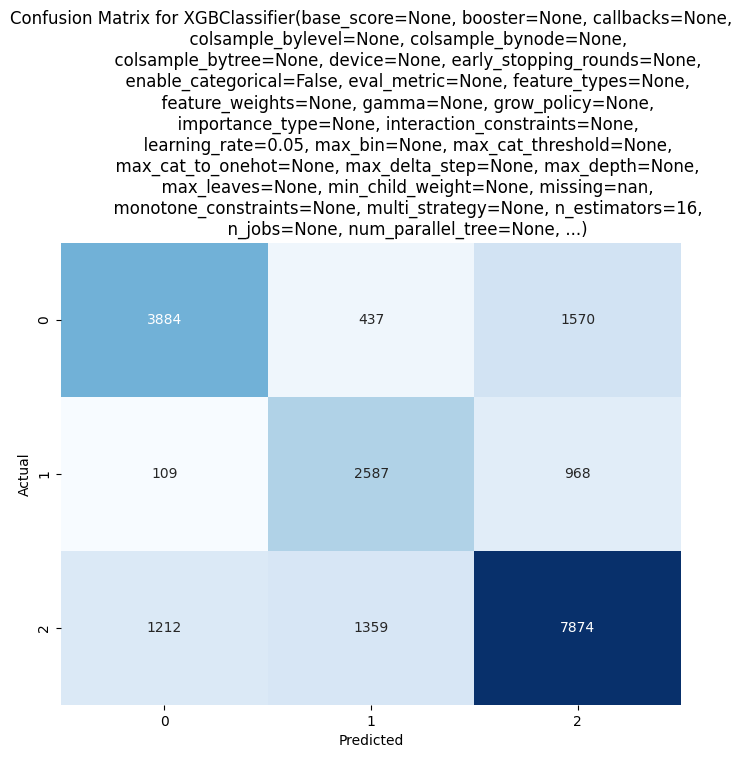

Classification Report for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=16,
              n_jobs=None, num_parallel_tree=None, ...):

              precision    recall  f1-score   support

           0       0.75      0.66      0.70      5891
           1       0.59      0.71      0.64      3664
           2       0.76      0.75      0.76     10

In [38]:
y_pred = best_model.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Plot a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model}')
plt.show()

# Print the classification report
print(f"Classification Report for {best_model}:\n")
print(report)



---

